# 🏊Predicting Public Pool Inspection Outcomes  
**Course Project | 90803 - Foundations of Machine Learning for Public Policy**  

---- 
**Team Members:** Ardak Baizhaxynova, Manraj Dhillon, Lucas Huynh

----

**Andrew IDs:** abaizhax, mdhillon, lqh

----

**Date:** April 2025  

---

## Project Overview
This project aims to build a machine learning model that predicts whether a public aquatic facility (e.g., pool, spa, hot tub) will pass or fail a routine health inspection. Using inspection records from the Allegheny County Health Department—hosted by the Western Pennsylvania Regional Data Center (WPRDC)—we perform exploratory data analysis (EDA), clean and preprocess the data, and develop a predictive model that helps identify facilities at risk of failure due to poor water chemistry or safety violations.

---

## Notebook Structure

1. **Introduction & Background**
2. **Exploratory Data Analysis (EDA)**
3. **Data Cleaning & Preprocessing**
4. **Feature Engineering**
5. **Modeling & Validation**
6. **Interpretability & Insights**
7. **Ethics, Limitations, and Policy Recommendations**
8. **Conclusion & Next Steps**

---

## Dataset
- **Source:** Western Pennsylvania Regional Data Center (WPRDC)  
- **Dataset:** Aquatic Inspections in Allegheny County  
- **Rows:** 2,507  
- **Columns:** 37  

---


## Packages to Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    confusion_matrix
)
import shap
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Basic EDA

In [3]:
file_path = "inspection_data.csv"
df = pd.read_csv(file_path)

# descriptive statistics
summary_stats = df.describe(include='all')

from IPython.display import display
display(summary_stats)

,_id,Inspection ID,Facility ID,Facility Name,Facility Address,Facility Address 2,Facility Municipality Name,Facility City,Facility County,Facility State,...,"pH Value, Deep",Cyanuric Acid,Turnover,Enclosure,Main Drain Visible,Safety Equipment,Disinfectant Level,pH Balance,No Imminent Health Hazards,Abated Date
count,2507.000000,2507.000000,2507.000000,2507,2507,72,2497,2507,2507,2502,...,944,883,1817.000000,2507,2507,2507,2507,2507,2507,2305
unique,NaN,NaN,NaN,577,484,13,75,77,1,1,...,24,38,NaN,1,2,2,1,2,2,493
top,NaN,NaN,NaN,COMFORT INN & SUITES NORTH SHORE - POOL,1000 SANDCASTLE DRIVE,#411,Pittsburgh,PITTSBURGH,Allegheny County,PA,...,7.4,<50,NaN,t,t,t,t,t,t,2023-08-04
freq,NaN,NaN,NaN,16,36,11,655,1089,2507,2502,...,364,229,NaN,2507,2477,1375,2507,2312,2378,38
mean,278454.000000,207224.982848,3746.968089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,273.074970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,723.852886,6391.343136,3410.995916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,506.960128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,277201.000000,195878.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,277827.500000,200878.500000,1341.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,60.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,278454.000000,206929.000000,2246.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,279080.500000,213778.500000,5902.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# basic data structure structure
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

Shape: (2507, 37)

Data Types:
 _id                             int64
Inspection ID                   int64
Facility ID                     int64
Facility Name                  object
Facility Address               object
Facility Address 2             object
Facility Municipality Name     object
Facility City                  object
Facility County                object
Facility State                 object
Facility Postal Code          float64
Facility Latitude             float64
Facility Longitude            float64
Venue Type                     object
Inspection Date                object
Inspection End                 object
Inspection Purpose             object
Inspection Passed              object
Inspection Number               int64
Inspector Name                 object
Free Chlorine, Shallow        float64
Free Chlorine, Deep           float64
Combined Chlorine, Shallow    float64
Combined Chlorine, Deep       float64
Free Bromine, Shallow         float64
Free Bromine, Deep

In [5]:
# convert object columns to numeric
for col in ["pH Value, Shallow", "pH Value, Deep", "Cyanuric Acid"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

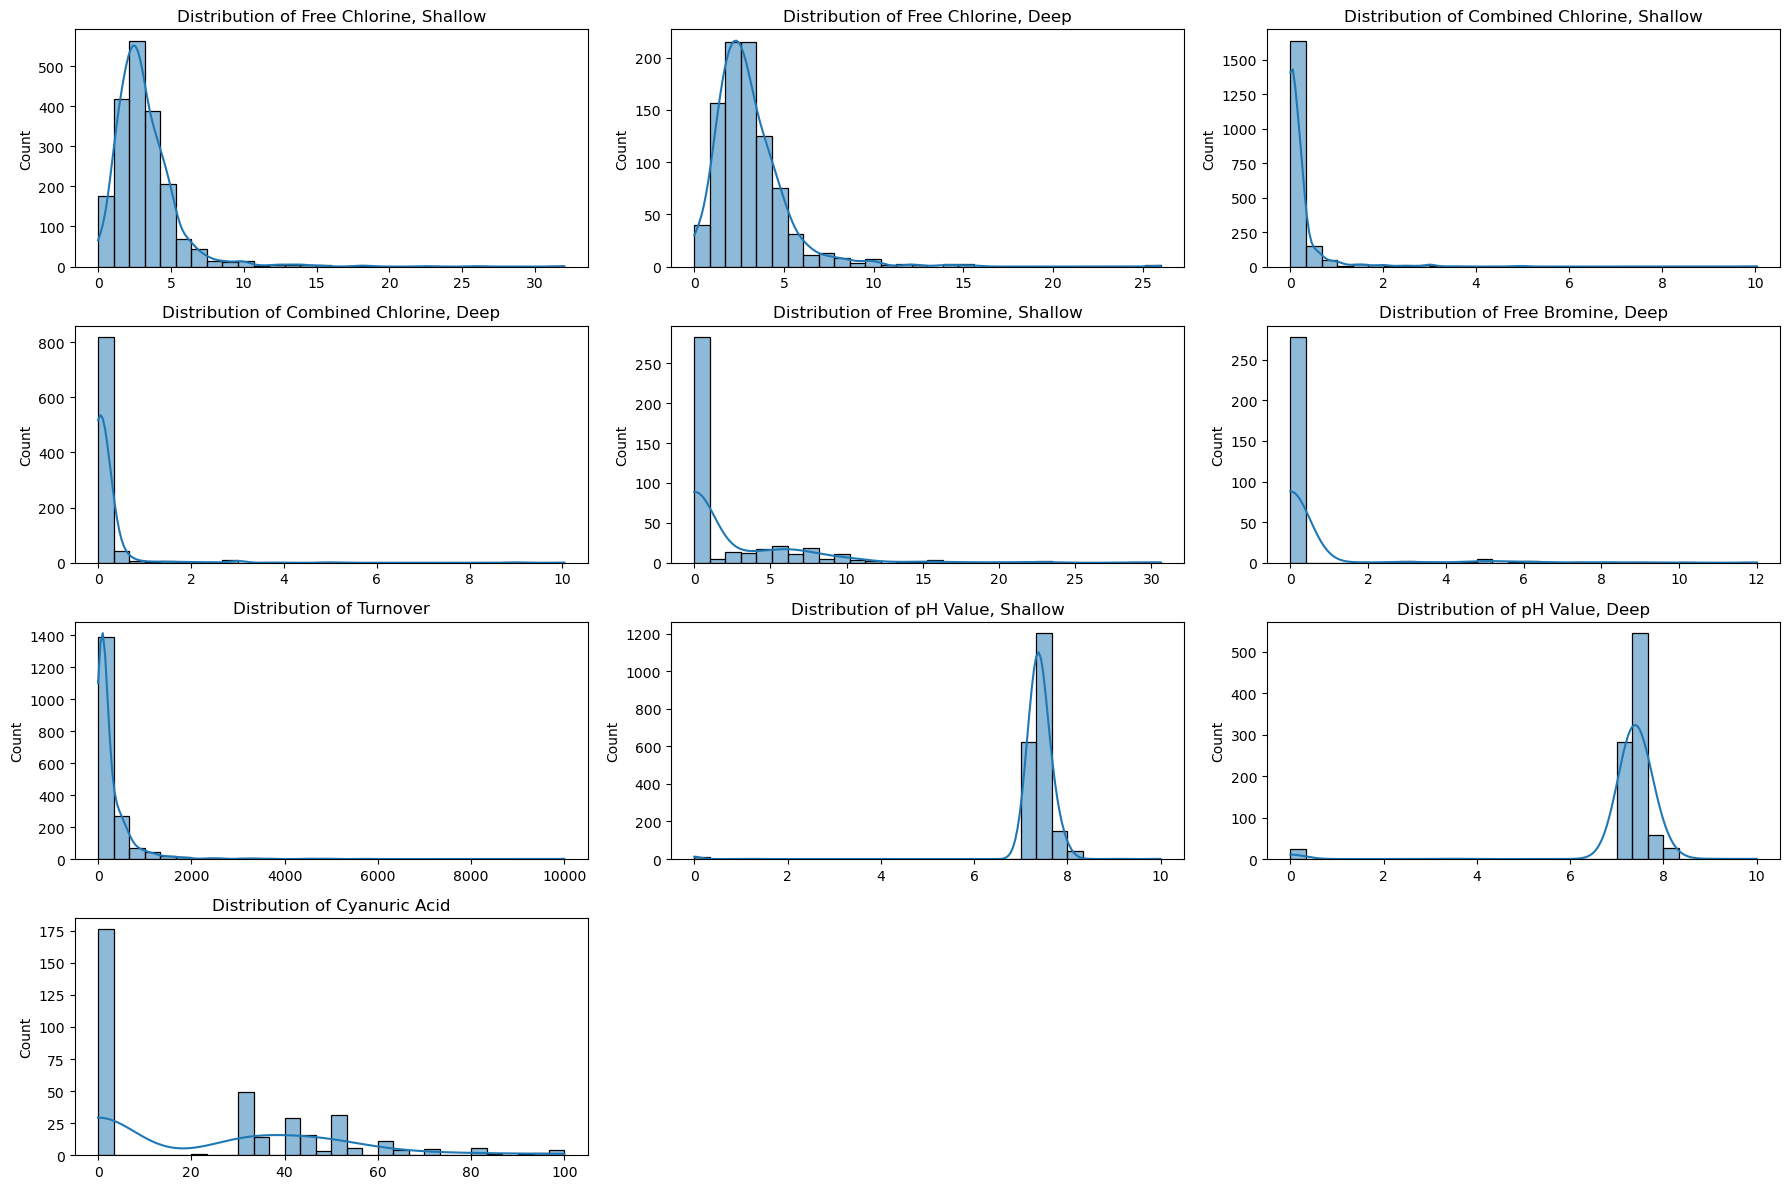

In [6]:
# visualize distribution of numerical features
num_cols = [
    "Free Chlorine, Shallow", "Free Chlorine, Deep",
    "Combined Chlorine, Shallow", "Combined Chlorine, Deep",
    "Free Bromine, Shallow", "Free Bromine, Deep",
    "Turnover", "pH Value, Shallow", "pH Value, Deep", "Cyanuric Acid"
]

plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols):
    plt.subplot(4, 3, i + 1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel('')
plt.tight_layout()
plt.show()

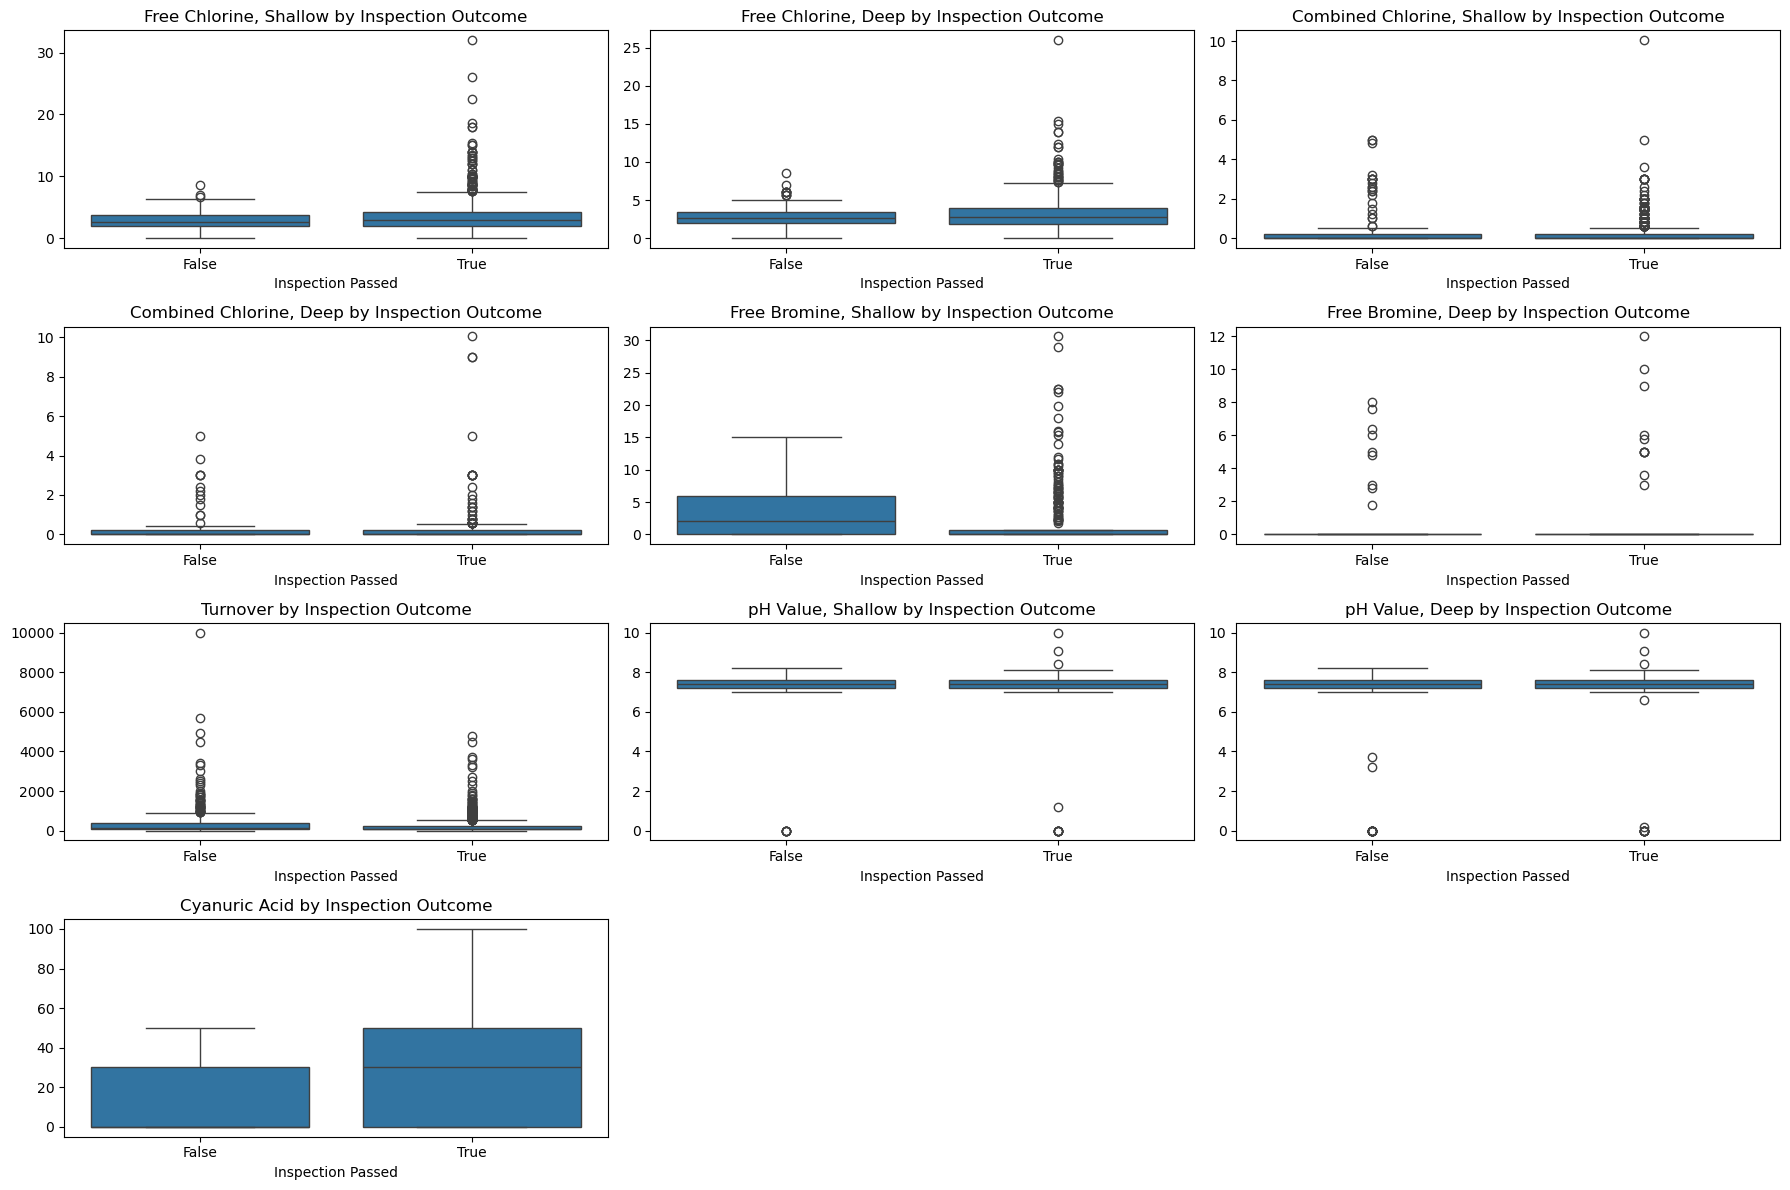

In [7]:
# target variable
df['Inspection Passed'] = df['Inspection Passed'].map({'t': True, 'f': False})

plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x='Inspection Passed', y=col, data=df)
    plt.title(f"{col} by Inspection Outcome")
    plt.xlabel('Inspection Passed')
    plt.ylabel('')
plt.tight_layout()
plt.show()

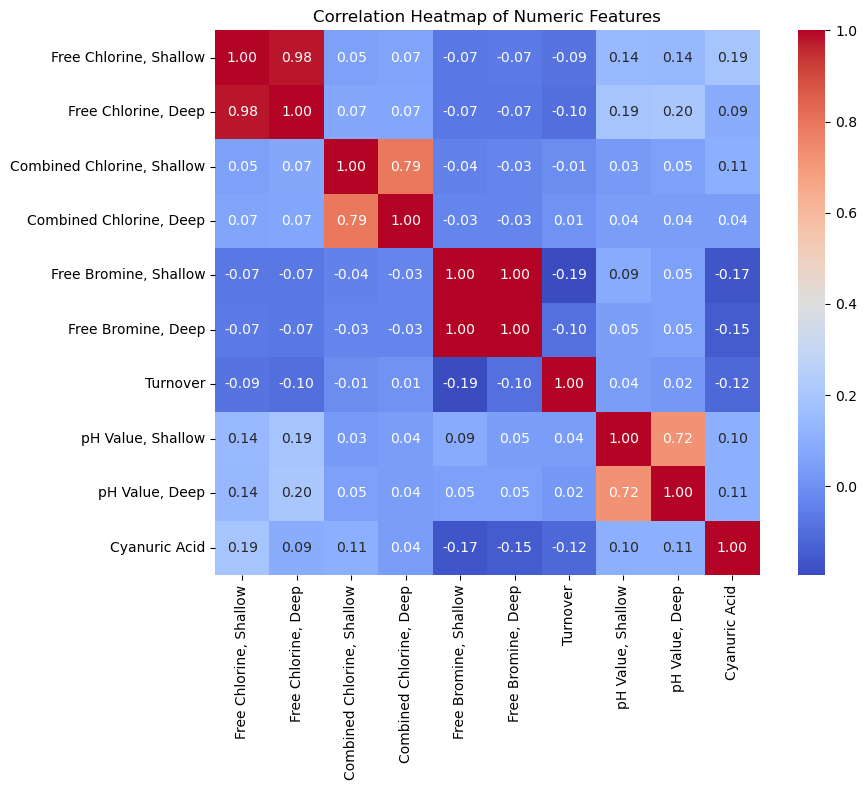

In [8]:
# correlation matrix
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

In [9]:
# safety flags
safety_flags = [
    "Enclosure", "Main Drain Visible", "Safety Equipment",
    "Disinfectant Level", "pH Balance", "No Imminent Health Hazards"
]

In [10]:
# convert 't'/'f' to True/False
for col in safety_flags:
    df[col] = df[col].map({'t': True, 'f': False})

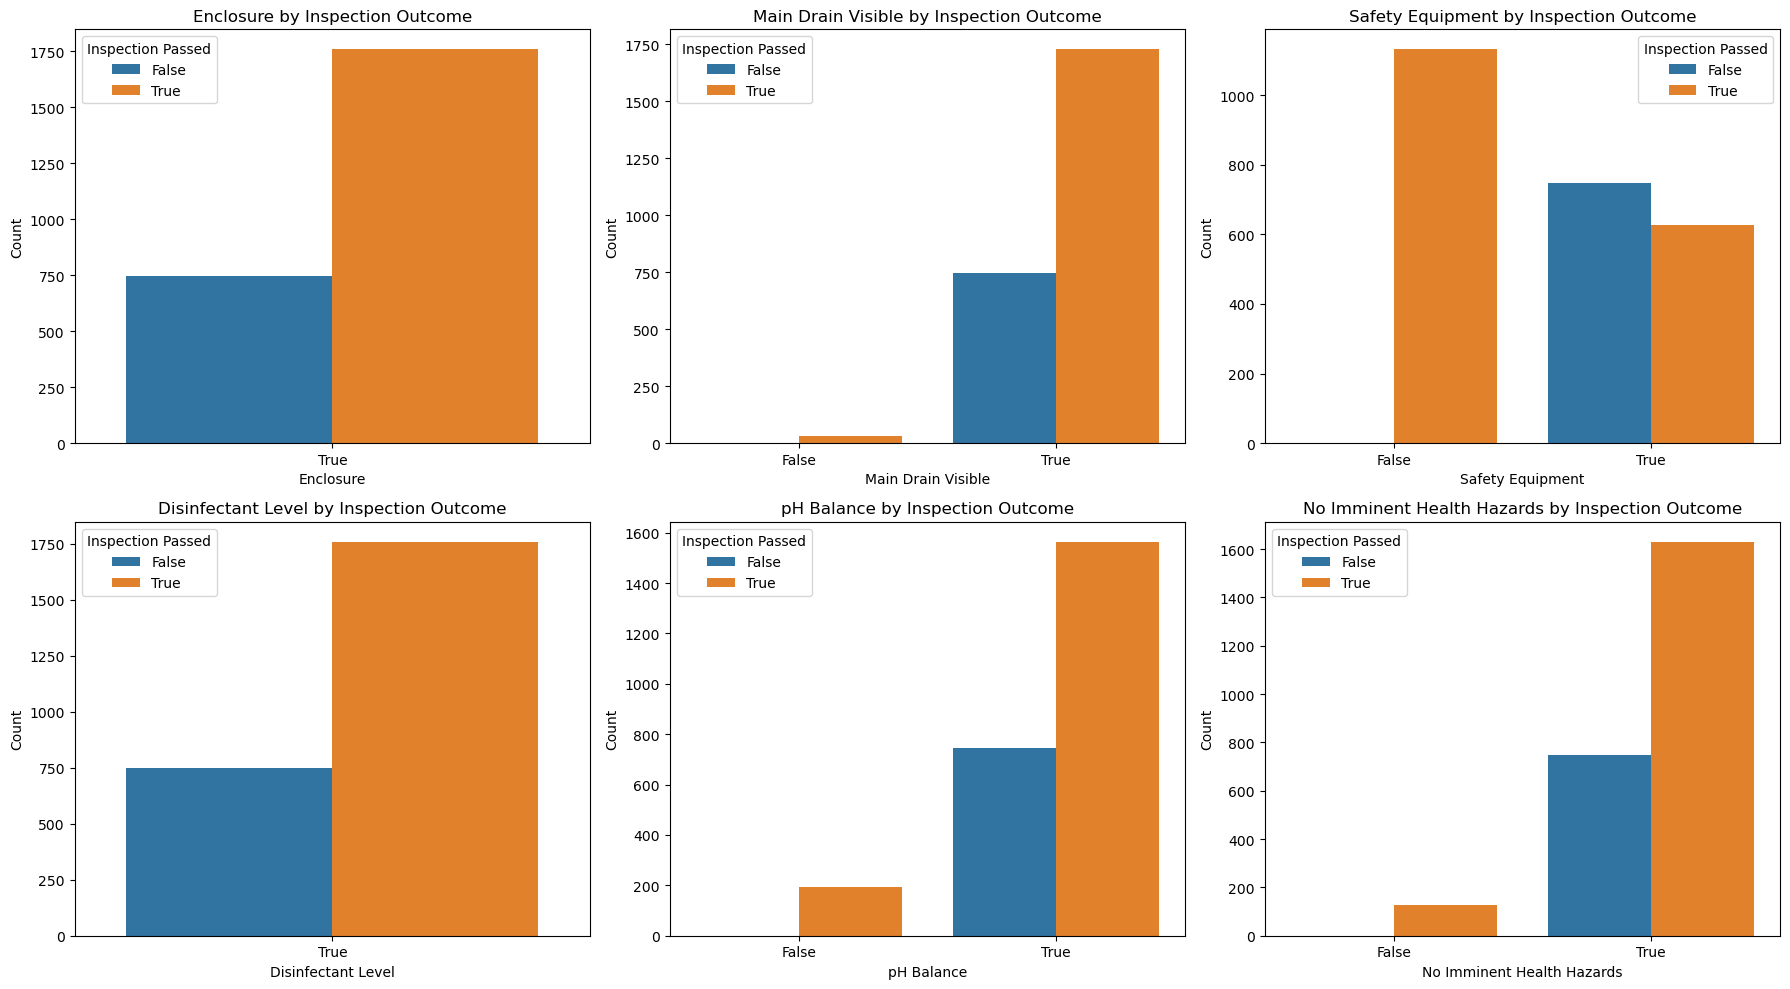

In [11]:
plt.figure(figsize=(18, 10))
for i, col in enumerate(safety_flags):
    plt.subplot(2, 3, i + 1)
    sns.countplot(data=df, x=col, hue="Inspection Passed")
    plt.title(f"{col} by Inspection Outcome")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

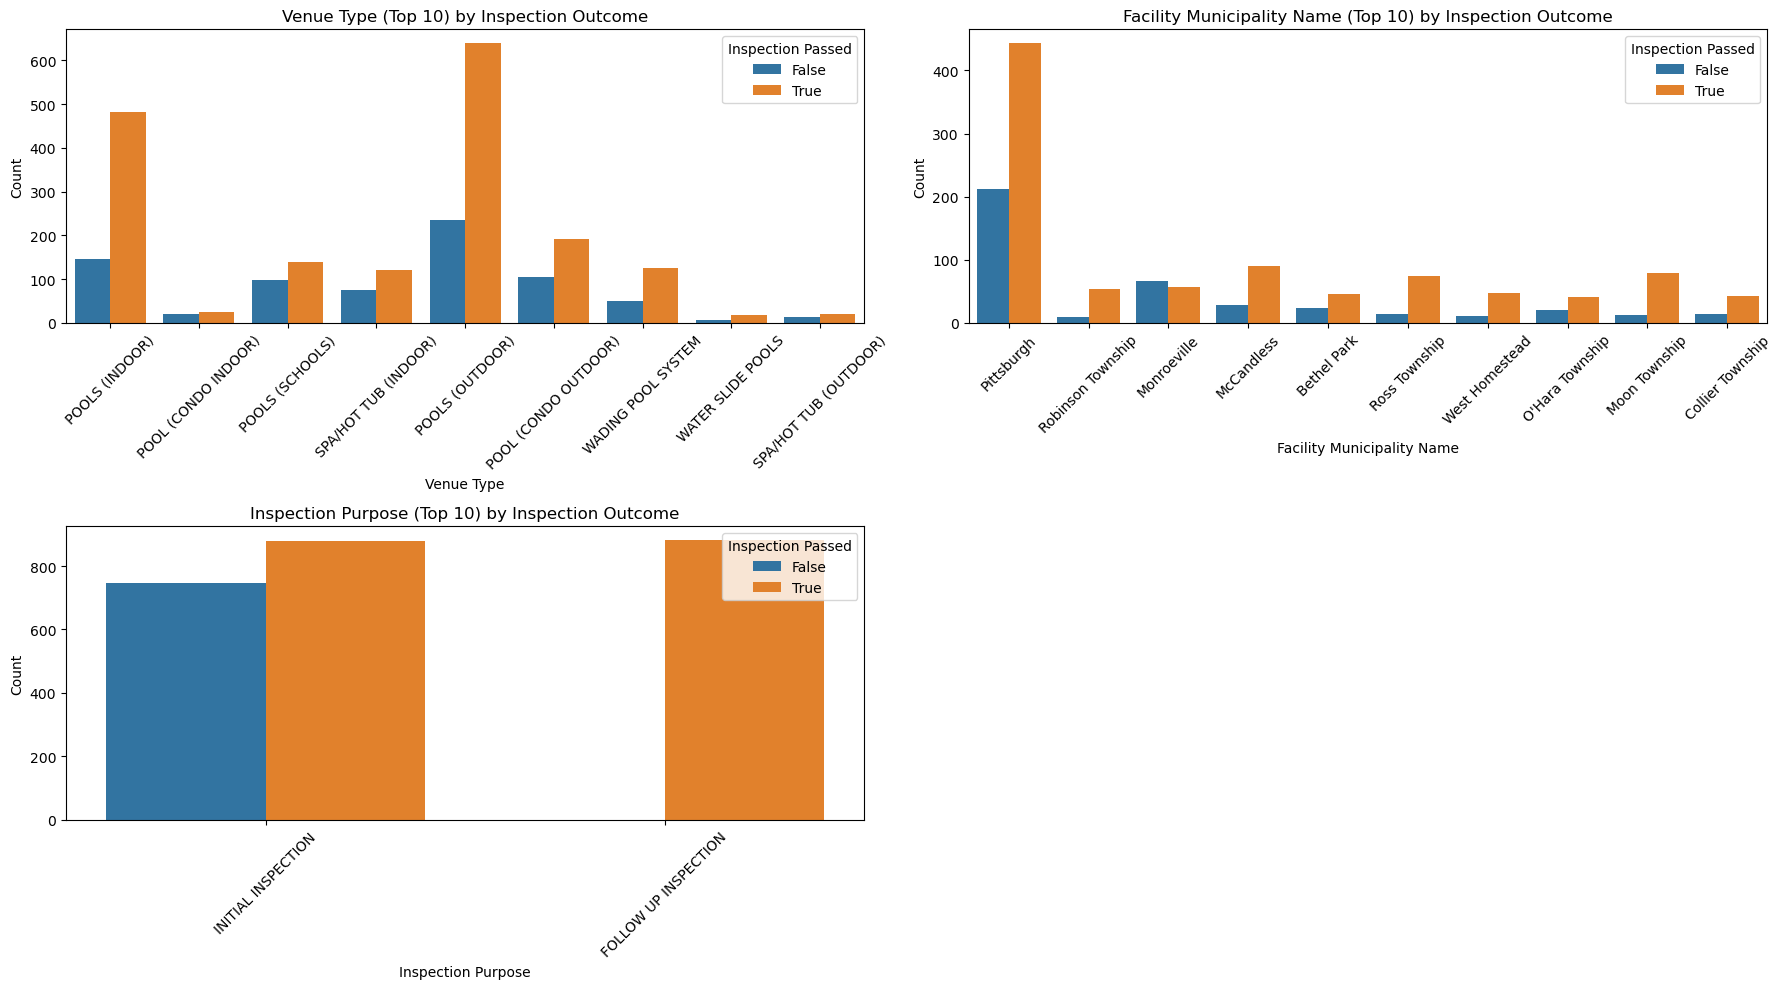

In [12]:
# categorical features
categorical_vars = [
    "Venue Type", "Facility Municipality Name", "Inspection Purpose"
]

plt.figure(figsize=(18, 10))
for i, col in enumerate(categorical_vars):
    plt.subplot(2, 2, i + 1)
    top_categories = df[col].value_counts().nlargest(10).index
    sns.countplot(data=df[df[col].isin(top_categories)], x=col, hue="Inspection Passed")
    plt.title(f"{col} (Top 10) by Inspection Outcome")
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Load and Inspect the Data

In [13]:
# load in data
file_path = "inspection_data.csv"
df = pd.read_csv(file_path)

In [14]:
df.head(10) # view first 10 rows

,_id,Inspection ID,Facility ID,Facility Name,Facility Address,Facility Address 2,Facility Municipality Name,Facility City,Facility County,Facility State,...,"pH Value, Deep",Cyanuric Acid,Turnover,Enclosure,Main Drain Visible,Safety Equipment,Disinfectant Level,pH Balance,No Imminent Health Hazards,Abated Date
0,277201,196055,7695,STAYBRIDGE SUITES POOL,239 SUMMIT PARK DRIVE,NaN,North Fayette Township,Pittsburgh,Allegheny County,PA,...,NaN,NaN,65.0,t,t,f,t,t,t,2022-10-24
1,277202,196136,1964,ATRIUM CONDO,307 S DITHRIDGE STREET,NaN,Pittsburgh,PITTSBURGH,Allegheny County,PA,...,NaN,NaN,115.0,t,t,t,t,t,t,2021-10-29
2,277203,196223,2379,HOLIDAY INN EXPRESS / PARKWAY CENTER INN - POOL,875 GREENTREE ROAD,NaN,Green Tree,PITTSBURGH,Allegheny County,PA,...,NaN,NaN,70.0,t,t,t,t,t,t,2021-10-29
3,277204,196340,4401,HOLIDAY INN EXPRESS & SUITES / NORTH SHORE POOL,228 FEDERAL STREET,NaN,Pittsburgh,PITTSBURGH,Allegheny County,PA,...,NaN,NaN,65.0,t,t,t,t,t,t,2021-11-08
4,277205,196560,2493,CMU / AQUATIC CENTER LAP POOL,5000 FORBES AVENUE,NaN,Pittsburgh,PITTSBURGH,Allegheny County,PA,...,NaN,NaN,600.0,t,t,t,t,t,t,2021-11-15
5,277206,196608,69,DUQUESNE UNIVERSITY / INDOOR POOL,1345 VICROY STREET,NaN,Pittsburgh,PITTSBURGH,Allegheny County,PA,...,NaN,NaN,325.0,t,t,f,t,t,t,2022-01-19
6,277207,196656,6243,STAYBRIDGE SUITES CRANBERRY POOL,915 BRUSH CREEK ROAD,NaN,Marshall Township,WARRENDALE,Allegheny County,PA,...,NaN,NaN,65.0,t,t,t,t,t,t,2021-12-21
7,277208,196701,4943,EMBASSY SUITES BY HILTON / POOL,535 SMITHFIELD STREET,NaN,Pittsburgh,PITTSBURGH,Allegheny County,PA,...,NaN,NaN,35.0,t,t,f,t,t,t,2022-01-20
8,277209,196708,1409,WYNDHAM GRAND PITTSBURGH - POOL,600 COMMONWEALTH PLACE,NaN,Pittsburgh,PITTSBURGH,Allegheny County,PA,...,NaN,NaN,90.0,t,t,t,t,t,t,2021-11-19
9,277210,196709,1410,WYNDHAM GRAND PITTSBURGH - SPA,600 COMMONWEALTH PLACE,NaN,Pittsburgh,PITTSBURGH,Allegheny County,PA,...,NaN,NaN,35.0,t,t,t,t,t,t,2021-11-19


In [15]:
df.shape # check number of rows and columns

(2507, 37)

## Baseline Class Distribution

In [16]:
# check class balance 
class_counts = df['Inspection Passed'].value_counts(dropna=False)
class_percent = df['Inspection Passed'].value_counts(normalize=True, dropna=False).round(3) * 100

class_balance = pd.DataFrame({
    "Count": class_counts,
    "Percent": class_percent
})

class_balance

,Count,Percent
Inspection Passed,,
t,1760,70.2
f,747,29.8


## 1. Identifying Columns with Sparse Values Or With Irrelevant Data

In [17]:
df.nunique(axis=0) # count unique values in each column

_id                           2507
Inspection ID                 2507
Facility ID                    602
Facility Name                  577
Facility Address               484
Facility Address 2              13
Facility Municipality Name      75
Facility City                   77
Facility County                  1
Facility State                   1
Facility Postal Code            77
Facility Latitude              426
Facility Longitude             427
Venue Type                       9
Inspection Date               2189
Inspection End                2200
Inspection Purpose               2
Inspection Passed                2
Inspection Number               12
Inspector Name                  26
Free Chlorine, Shallow          78
Free Chlorine, Deep             61
Combined Chlorine, Shallow      26
Combined Chlorine, Deep         22
Free Bromine, Shallow           60
Free Bromine, Deep              15
pH Value, Shallow               26
pH Value, Deep                  24
Cyanuric Acid       

In [18]:
df.columns[df.nunique() == 1] # columns with one unique value

Index(['Facility County', 'Facility State', 'Enclosure', 'Disinfectant Level'], dtype='object')

In [19]:
df.nunique()/len(df)*100 # percentage of unique values in each column

_id                           100.000000
Inspection ID                 100.000000
Facility ID                    24.012764
Facility Name                  23.015556
Facility Address               19.305943
Facility Address 2              0.518548
Facility Municipality Name      2.991623
Facility City                   3.071400
Facility County                 0.039888
Facility State                  0.039888
Facility Postal Code            3.071400
Facility Latitude              16.992421
Facility Longitude             17.032310
Venue Type                      0.358995
Inspection Date                87.315517
Inspection End                 87.754288
Inspection Purpose              0.079777
Inspection Passed               0.079777
Inspection Number               0.478660
Inspector Name                  1.037096
Free Chlorine, Shallow          3.111288
Free Chlorine, Deep             2.433187
Combined Chlorine, Shallow      1.037096
Combined Chlorine, Deep         0.877543
Free Bromine, Sh

In [20]:
list(df.columns[df.nunique()/len(df) < 0.01]) # sparse columns

['Facility Address 2',
 'Facility County',
 'Facility State',
 'Venue Type',
 'Inspection Purpose',
 'Inspection Passed',
 'Inspection Number',
 'Combined Chlorine, Deep',
 'Free Bromine, Deep',
 'pH Value, Deep',
 'Enclosure',
 'Main Drain Visible',
 'Safety Equipment',
 'Disinfectant Level',
 'pH Balance',
 'No Imminent Health Hazards']

In [21]:
for col in df.columns:
    print(col, "→", df[col].unique())

_id → [277201 277202 277203 ... 279705 279706 279707]
Inspection ID → [196055 196136 196223 ... 220149 220247 220296]
Facility ID → [ 7695  1964  2379  4401  2493    69  6243  4943  1409  1410  6464  6463
  2512  5763  7261   293  1399  1233  1995  2456  2463  2320  2318  2153
   526  2319  1007   213  9337  9339  1960 10317  1028  2307 10577  2003
  1200  2441  4961  1970 10000  1494  2020  2283  2234  5961  1493  2388
  2212  7341  1240   372   669 10638  7206  2113   446  2194  2233  6941
  4184  5481  1241  2183  2253   274  2387  1473  2357  3843   683  2428
  1201  1098  2366  5142  2117    56  7574   350  2444  2116  2276  1972
  2486  2507  2356  2297  2223  2255  2180  5426  2047  1971  2065  2088
  2023  2201  1227  9697   358  5983  8137  2196  9737  1985  1317  1163
  2298  2470  2475  2488   780  2315   850   750  2448   555  9717  2293
    74  1301  2069  2197   666  6002  8897  8898   414  1010  2452  2412
  2316   770 10479  2537  5621  5443 10679  2474  4141   167  130

In [22]:
# Columns to drop (based on domain irrelevance or redundancy)
original_shape = df.shape

drop_sparse_cols = [
    '_id',
    'Facility Address 2',
    'Facility County',
    'Facility State',
    'Facility Latitude',
    'Facility Longitude',
    'Inspection End',
    'Enclosure',
    'Disinfectant Level',
    'Abated Date'
]

# Drop the columns
df.drop(columns=drop_sparse_cols, inplace = True)

print("Original shape:", original_shape)
print("New shape after dropping sparse columns:", df.shape)

Original shape: (2507, 37)
New shape after dropping sparse columns: (2507, 27)


We evaluated columns with fewer than 1% unique values or those deemed redundant based on domain knowledge. Below is a summary of the decisions made for each:

---

#### Columns Dropped

| Column                   | Reason for Removal                                                                 |
|--------------------------|------------------------------------------------------------------------------------|
| `_id`                    | Redundant with `Inspection ID`; only one unique identifier is needed               |
| `Facility Address 2`     | Often contains PO boxes or apartment units; adds no predictive value               |
| `Facility County`        | All rows are in Allegheny County; no variation                                    |
| `Facility State`         | All rows are in Pennsylvania (`PA`); no variation                                 |
| `Facility Latitude`      | Redundant with `Facility Municipality Name` and `Facility Postal Code`            |
| `Facility Longitude`     | Same as above; doesn't add new location insight                                   |
| `Enclosure`              | Nearly always `True`; lacks variability                                           |
| `Disinfectant Level`     | Also nearly always `True`; not helpful for classification                         |
| `Abated Date`            | Indicates when a violation was resolved; occurs **after** inspection — not useful for prediction |
| `Inspection End`         | Only need starting date of inspection                                             |

---

#### Sparse Columns Retained (Justification Provided)

| Column                      | Reason for Retention                                                                 |
|-----------------------------|--------------------------------------------------------------------------------------|
| `Venue Type`                | Though sparse, it may capture important differences in facility type (e.g., hotel vs. public pool) |
| `Inspection Purpose`        | May help distinguish routine vs. complaint-driven inspections                      |
| `Inspection Passed`         | Target variable — required for modeling outcome                                  |
| `Inspection Number`         | May reflect how often a facility is inspected; can signal recurring issues          |
| `Combined Chlorine, Deep`   | Useful for large pools where deep-end chemical levels are reported                  |
| `Free Bromine, Deep`        | Relevant for bromine-treated pools (niche but valid chemistry feature)              |
| `pH Value, Deep`            | Important in deep-end pool regulation; sparse but chemically meaningful             |
| `Main Drain Visible`        | Indicates clarity of water — a strong indicator of safety/hazards                  |
| `Safety Equipment`          | Critical safety flag — presence/absence is inspection-relevant                      |
| `pH Balance`                | Even if inconsistently reported, it's a key indicator of water chemistry compliance |

---


In [23]:
df.head(10)

,Inspection ID,Facility ID,Facility Name,Facility Address,Facility Municipality Name,Facility City,Facility Postal Code,Venue Type,Inspection Date,Inspection Purpose,...,"Free Bromine, Shallow","Free Bromine, Deep","pH Value, Shallow","pH Value, Deep",Cyanuric Acid,Turnover,Main Drain Visible,Safety Equipment,pH Balance,No Imminent Health Hazards
0,196055,7695,STAYBRIDGE SUITES POOL,239 SUMMIT PARK DRIVE,North Fayette Township,Pittsburgh,15275.0,POOLS (INDOOR),2021-10-18T12:25:00,INITIAL INSPECTION,...,NaN,NaN,7.2,NaN,NaN,65.0,t,f,t,t
1,196136,1964,ATRIUM CONDO,307 S DITHRIDGE STREET,Pittsburgh,PITTSBURGH,15213.0,POOL (CONDO INDOOR),2021-10-21T10:00:00,INITIAL INSPECTION,...,NaN,NaN,7.8,NaN,NaN,115.0,t,t,t,t
2,196223,2379,HOLIDAY INN EXPRESS / PARKWAY CENTER INN - POOL,875 GREENTREE ROAD,Green Tree,PITTSBURGH,15220.0,POOLS (INDOOR),2021-10-28T15:25:00,INITIAL INSPECTION,...,5.20,NaN,7.6,NaN,NaN,70.0,t,t,t,t
3,196340,4401,HOLIDAY INN EXPRESS & SUITES / NORTH SHORE POOL,228 FEDERAL STREET,Pittsburgh,PITTSBURGH,15212.0,POOLS (INDOOR),2021-11-03T13:45:00,INITIAL INSPECTION,...,7.65,NaN,7.4,NaN,NaN,65.0,t,t,t,t
4,196560,2493,CMU / AQUATIC CENTER LAP POOL,5000 FORBES AVENUE,Pittsburgh,PITTSBURGH,15217.0,POOLS (SCHOOLS),2021-11-10T02:15:00,INITIAL INSPECTION,...,NaN,NaN,7.4,NaN,NaN,600.0,t,t,t,t
5,196608,69,DUQUESNE UNIVERSITY / INDOOR POOL,1345 VICROY STREET,Pittsburgh,PITTSBURGH,15282.0,POOLS (SCHOOLS),2021-11-12T01:15:00,INITIAL INSPECTION,...,NaN,NaN,7.5,NaN,NaN,325.0,t,f,t,t
6,196656,6243,STAYBRIDGE SUITES CRANBERRY POOL,915 BRUSH CREEK ROAD,Marshall Township,WARRENDALE,15086.0,POOLS (INDOOR),2021-11-17T14:50:00,INITIAL INSPECTION,...,2.25,NaN,7.6,NaN,NaN,65.0,t,t,t,t
7,196701,4943,EMBASSY SUITES BY HILTON / POOL,535 SMITHFIELD STREET,Pittsburgh,PITTSBURGH,15222.0,POOLS (INDOOR),2021-11-17T10:30:00,INITIAL INSPECTION,...,NaN,NaN,7.2,NaN,NaN,35.0,t,f,t,t
8,196708,1409,WYNDHAM GRAND PITTSBURGH - POOL,600 COMMONWEALTH PLACE,Pittsburgh,PITTSBURGH,15222.0,POOLS (INDOOR),2021-11-17T01:00:00,INITIAL INSPECTION,...,6.00,NaN,7.8,NaN,NaN,90.0,t,t,t,t
9,196709,1410,WYNDHAM GRAND PITTSBURGH - SPA,600 COMMONWEALTH PLACE,Pittsburgh,PITTSBURGH,15222.0,SPA/HOT TUB (INDOOR),2021-11-17T01:30:00,INITIAL INSPECTION,...,6.00,NaN,7.2,NaN,NaN,35.0,t,t,t,t


## 1.5. Data Standardization

In [24]:
replace_dict = {
    'Mccandless': 'McCandless',
    'Mckeesport': 'McKeesport',
    'Ohio': 'Ohio Township',
    'Elizabeth': 'Elizabeth Township', 
    'Upper St Clair Township': 'Upper St. Clair Township'
}

df['Facility Municipality Name'] = df['Facility Municipality Name'].replace(replace_dict)
df['Facility Municipality Name'] = df['Facility Municipality Name'].str.title().str.strip()
df['Facility Municipality Name'] = df['Facility Municipality Name'].fillna('Unknown')

print(np.sort(df['Facility Municipality Name'].unique()))

['Aleppo Township' 'Aspinwall' 'Avalon' 'Baldwin' 'Bellevue'
 'Ben Avon Heights' 'Bethel Park' 'Brentwood' 'Carnegie' 'Castle Shannon'
 'Churchill' 'Clairton' 'Collier Township' 'Crafton' 'Dormont' 'Edgewood'
 'Edgeworth' 'Elizabeth' 'Elizabeth Township' 'Emsworth' 'Etna'
 'Findlay Township' 'Forest Hills' 'Fox Chapel' 'Franklin Park'
 'Frazer Township' 'Green Tree' 'Hampton Township' 'Harmar Township'
 'Harrison Township' 'Indiana Township' 'Jefferson Hills'
 'Kennedy Township' 'Kilbuck Township' 'Marshall Township' 'Mccandless'
 'Mckeesport' 'Monroeville' 'Moon Township' 'Mount Lebanon' 'Munhall'
 'Neville Township' 'North Fayette Township' 'North Versailles Township'
 "O'Hara Township" 'Oakmont' 'Ohio' 'Ohio Township' 'Penn Hills'
 'Pennsbury Village' 'Pine Township' 'Pittsburgh' 'Pleasant Hills' 'Plum'
 'Richland Township' 'Robinson Township' 'Ross Township' 'Rosslyn Farms'
 'Scott Township' 'Sewickley' 'Shaler Township' 'South Fayette Township'
 'South Park Township' 'Unknown' 'Up

In [25]:
replace_city = {
    'PITTSBURGH': 'Pittsburgh',
    'PGH': 'Pittsburgh',
    'PGH.': 'Pittsburgh',
    'Pgh': 'Pittsburgh',
    'Pgh.': 'Pittsburgh',
    'MC KEESPORT': 'McKeesport',
    'MC CANDLESS': 'McCandless',
    'MC CANDLESS': 'McCandless',
    'MC KEES ROCKS': 'McKees Rocks',
    'MCKEES ROCKS': 'McKees Rocks',
    'MCKEESPORT': 'McKeesport',
    'Mc Candless': 'McCandless',
    'Mc Kees Rocks': 'McKees Rocks',
    'Mc Keesport': 'McKeesport',
    'Mcdonald': 'McDonald',
    'COROAPOLIS': 'Coraopolis',
    'Coroapolis': 'Coraopolis',
    'KENNEDY TWP.': 'Kennedy Township',
    'Kennedy Twp.': 'Kennedy Township',
    'PLUM BOROUGH': 'Plum',
    'Plum Borough': 'Plum',
    'BETHEL PARK': 'Bethel Park',
    'WEST MIFFLIN': 'West Mifflin',
    'WHITE OAK': 'White Oak',
    'ALLISON PARK': 'Allison Park',
    'BRADFORD WOODS': 'Bradford Woods',
    'WEST HOMESTEAD': 'West Homestead',
    'JEFFERSON HILLS': 'Jefferson Hills',
    'ROSSLYN FARMS': 'Rosslyn Farms',
    'NORTH VERSAILLES': 'North Versailles',
    'BUENA VISTA': 'Buena Vista',
    'TARENTUM': 'Tarentum',
    'FINDLAY': 'Findlay Township',
    'OAKMONT': 'Oakmont',
    'WILKINS': 'Wilkins Township',
    'CARNEGIE': 'Carnegie',
    'CHURCHILL': 'Churchill',
    'INDIANOLA': 'Indianola',
    'BELLEVUE': 'Bellevue',
}

df['Facility City'] = df['Facility City'].str.strip().str.title()
df['Facility City'] = df['Facility City'].replace(replace_city)

print(np.sort(df['Facility City'].unique()))

['Allison Park' 'Aspinwall' 'Bellevue' 'Bethel Park' 'Bradford Woods'
 'Bridgeville' 'Buena Vista' 'Carnegie' 'Cheswick' 'Churchill' 'Clairton'
 'Clinton' 'Coraopolis' 'Elizabeth' 'Findlay' 'Forest Hills' 'Gibsonia'
 'Glenshaw' 'Homestead' 'Imperial' 'Indianola' 'Jefferson Hills'
 'Kennedy Township' 'Library' 'Mars' 'McCandless' 'McDonald'
 'McKees Rocks' 'McKeesport' 'Mckees Rocks' 'Mckeesport' 'Monroeville'
 'Moon Township' 'Munhall' 'Natrona Heights' 'North Versailles' 'Oakdale'
 'Oakmont' 'Pine' 'Pittsburgh' 'Pleasant Hills' 'Plum' 'Presto' 'Robinson'
 'Rosslyn Farms' 'Sewickley' 'South Park' 'Tarentum' 'Verona' 'Warrendale'
 'West Homestead' 'West Mifflin' 'Wexford' 'White Oak' 'Wilkins'
 'Wilkinsburg' 'Wilmerding']


In [26]:
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])

df['Inspection Year'] = df['Inspection Date'].dt.year
df['Inspection Month'] = df['Inspection Date'].dt.month

print(df[['Inspection Date', 'Inspection Year', 'Inspection Month']].head())

      Inspection Date  Inspection Year  Inspection Month
0 2021-10-18 12:25:00           2021.0              10.0
1 2021-10-21 10:00:00           2021.0              10.0
2 2021-10-28 15:25:00           2021.0              10.0
3 2021-11-03 13:45:00           2021.0              11.0
4 2021-11-10 02:15:00           2021.0              11.0


In [27]:
bool_cols = [
    'Inspection Passed', 
    'Main Drain Visible', 
    'Safety Equipment', 
    'pH Balance', 
    'No Imminent Health Hazards'
]

df[bool_cols] = df[bool_cols].applymap(lambda x: True if x == 't' else False)

print(df[bool_cols].head())

   Inspection Passed  Main Drain Visible  Safety Equipment  pH Balance  \
0               True                True             False        True   
1              False                True              True        True   
2              False                True              True        True   
3              False                True              True        True   
4              False                True              True        True   

   No Imminent Health Hazards  
0                        True  
1                        True  
2                        True  
3                        True  
4                        True  


/var/folders/hj/_jmscth928bcdm9fr013zqzr0000gn/T/ipykernel_47411/1069222412.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[bool_cols] = df[bool_cols].applymap(lambda x: True if x == 't' else False)


In [28]:
cols_to_check = [
    'Free Chlorine, Shallow',
    'Free Chlorine, Deep',
    'Combined Chlorine, Shallow',
    'Combined Chlorine, Deep',
    'Free Bromine, Shallow',
    'Free Bromine, Deep',
    'pH Value, Shallow',
    'pH Value, Deep',
    'Cyanuric Acid'
]

for col in cols_to_check:
    print(f"{col}: {df[col].dtype}")

Free Chlorine, Shallow: float64
Free Chlorine, Deep: float64
Combined Chlorine, Shallow: float64
Combined Chlorine, Deep: float64
Free Bromine, Shallow: float64
Free Bromine, Deep: float64
pH Value, Shallow: object
pH Value, Deep: object
Cyanuric Acid: object


In [29]:
def clean_ph(value):
    if pd.isna(value):
        return np.nan
    value = str(value).strip().replace('<', '').replace('>', '').replace('=', '').replace(' ', '')
    try:
        fval = float(value)
        if fval == 0 or fval > 14:  # unlikely values
            return np.nan
        return fval
    except:
        return np.nan

def bin_ph(value):
    if pd.isna(value):
        return np.nan
    if value < 7.2:
        return 'Low'
    elif 7.2 <= value <= 7.8:
        return 'Normal'
    else:
        return 'High'

for col in ['pH Value, Shallow', 'pH Value, Deep']:
    df[col + ' (Cleaned)'] = df[col].apply(clean_ph)
    df[col + ' (Category)'] = df[col + ' (Cleaned)'].apply(bin_ph)

def clean_cya(value):
    if pd.isna(value):
        return np.nan
    value = str(value).strip().replace('<', '').replace('>', '').replace('=', '').replace('ppm', '').replace('PPM', '')
    value = value.replace(',', '').replace(' ', '')
    try:
        return float(value)
    except:
        return np.nan

def bin_cya(value):
    if pd.isna(value):
        return np.nan
    if value < 30:
        return 'Low'
    elif 30 <= value <= 50:
        return 'Ideal'
    else:
        return 'High'

df['Cyanuric Acid (Cleaned)'] = df['Cyanuric Acid'].apply(clean_cya)
df['Cyanuric Acid (Category)'] = df['Cyanuric Acid (Cleaned)'].apply(bin_cya)


In [30]:
print("\n--- Non-null pH Value, Shallow (Category) ---")
print(df[df['pH Value, Shallow (Category)'].notna()][['pH Value, Shallow', 'pH Value, Shallow (Cleaned)', 'pH Value, Shallow (Category)']].head())

print("\n--- Non-null pH Value, Deep (Category) ---")
print(df[df['pH Value, Deep (Category)'].notna()][['pH Value, Deep', 'pH Value, Deep (Cleaned)', 'pH Value, Deep (Category)']].head())

print("\n--- Non-null Cyanuric Acid (Category) ---")
print(df[df['Cyanuric Acid (Category)'].notna()][['Cyanuric Acid', 'Cyanuric Acid (Cleaned)', 'Cyanuric Acid (Category)']].head())

print("\n--- Value Counts (pH Value, Shallow) ---")
print(df['pH Value, Shallow (Category)'].dropna().value_counts())

print("\n--- Value Counts (pH Value, Deep) ---")
print(df['pH Value, Deep (Category)'].dropna().value_counts())

print("\n--- Value Counts (Cyanuric Acid) ---")
print(df['Cyanuric Acid (Category)'].dropna().value_counts())



--- Non-null pH Value, Shallow (Category) ---
  pH Value, Shallow  pH Value, Shallow (Cleaned) pH Value, Shallow (Category)
0               7.2                          7.2                       Normal
1               7.8                          7.8                       Normal
2               7.6                          7.6                       Normal
3               7.4                          7.4                       Normal
4               7.4                          7.4                       Normal

--- Non-null pH Value, Deep (Category) ---
   pH Value, Deep  pH Value, Deep (Cleaned) pH Value, Deep (Category)
23            7.4                       7.4                    Normal
27            7.6                       7.6                    Normal
30            7.2                       7.2                    Normal
32            7.6                       7.6                    Normal
33            7.6                       7.6                    Normal

--- Non-null Cyanuri

In [31]:
df.head(10)

,Inspection ID,Facility ID,Facility Name,Facility Address,Facility Municipality Name,Facility City,Facility Postal Code,Venue Type,Inspection Date,Inspection Purpose,...,pH Balance,No Imminent Health Hazards,Inspection Year,Inspection Month,"pH Value, Shallow (Cleaned)","pH Value, Shallow (Category)","pH Value, Deep (Cleaned)","pH Value, Deep (Category)",Cyanuric Acid (Cleaned),Cyanuric Acid (Category)
0,196055,7695,STAYBRIDGE SUITES POOL,239 SUMMIT PARK DRIVE,North Fayette Township,Pittsburgh,15275.0,POOLS (INDOOR),2021-10-18 12:25:00,INITIAL INSPECTION,...,True,True,2021.0,10.0,7.2,Normal,NaN,NaN,NaN,NaN
1,196136,1964,ATRIUM CONDO,307 S DITHRIDGE STREET,Pittsburgh,Pittsburgh,15213.0,POOL (CONDO INDOOR),2021-10-21 10:00:00,INITIAL INSPECTION,...,True,True,2021.0,10.0,7.8,Normal,NaN,NaN,NaN,NaN
2,196223,2379,HOLIDAY INN EXPRESS / PARKWAY CENTER INN - POOL,875 GREENTREE ROAD,Green Tree,Pittsburgh,15220.0,POOLS (INDOOR),2021-10-28 15:25:00,INITIAL INSPECTION,...,True,True,2021.0,10.0,7.6,Normal,NaN,NaN,NaN,NaN
3,196340,4401,HOLIDAY INN EXPRESS & SUITES / NORTH SHORE POOL,228 FEDERAL STREET,Pittsburgh,Pittsburgh,15212.0,POOLS (INDOOR),2021-11-03 13:45:00,INITIAL INSPECTION,...,True,True,2021.0,11.0,7.4,Normal,NaN,NaN,NaN,NaN
4,196560,2493,CMU / AQUATIC CENTER LAP POOL,5000 FORBES AVENUE,Pittsburgh,Pittsburgh,15217.0,POOLS (SCHOOLS),2021-11-10 02:15:00,INITIAL INSPECTION,...,True,True,2021.0,11.0,7.4,Normal,NaN,NaN,NaN,NaN
5,196608,69,DUQUESNE UNIVERSITY / INDOOR POOL,1345 VICROY STREET,Pittsburgh,Pittsburgh,15282.0,POOLS (SCHOOLS),2021-11-12 01:15:00,INITIAL INSPECTION,...,True,True,2021.0,11.0,7.5,Normal,NaN,NaN,NaN,NaN
6,196656,6243,STAYBRIDGE SUITES CRANBERRY POOL,915 BRUSH CREEK ROAD,Marshall Township,Warrendale,15086.0,POOLS (INDOOR),2021-11-17 14:50:00,INITIAL INSPECTION,...,True,True,2021.0,11.0,7.6,Normal,NaN,NaN,NaN,NaN
7,196701,4943,EMBASSY SUITES BY HILTON / POOL,535 SMITHFIELD STREET,Pittsburgh,Pittsburgh,15222.0,POOLS (INDOOR),2021-11-17 10:30:00,INITIAL INSPECTION,...,True,True,2021.0,11.0,7.2,Normal,NaN,NaN,NaN,NaN
8,196708,1409,WYNDHAM GRAND PITTSBURGH - POOL,600 COMMONWEALTH PLACE,Pittsburgh,Pittsburgh,15222.0,POOLS (INDOOR),2021-11-17 01:00:00,INITIAL INSPECTION,...,True,True,2021.0,11.0,7.8,Normal,NaN,NaN,NaN,NaN
9,196709,1410,WYNDHAM GRAND PITTSBURGH - SPA,600 COMMONWEALTH PLACE,Pittsburgh,Pittsburgh,15222.0,SPA/HOT TUB (INDOOR),2021-11-17 01:30:00,INITIAL INSPECTION,...,True,True,2021.0,11.0,7.2,Normal,NaN,NaN,NaN,NaN


# Data Standardization Summary

---

## Location Fields

### `Facility Municipality Name`
- Converted to title case and stripped extra whitespace.
- Filled missing values with `'Unknown'`.
- Replaced known mislabelings (e.g., `'Mckeesport' → 'McKeesport'`, `'Ohio' → 'Ohio Township'`, etc.).

### `Facility City`
- Converted to title case and stripped extra whitespace.
- Replaced inconsistent or incorrect values using a custom mapping dictionary (e.g., `'PGH' → 'Pittsburgh'`, `'MC KEESPORT' → 'McKeesport'`).
- Grouped variants into standardized city names.

---

## Boolean Fields

Converted `'t'` / `'f'` strings into Python booleans (`True` / `False`) for the following columns:
- `Inspection Passed`
- `Main Drain Visible`
- `Safety Equipment`
- `pH Balance`
- `No Imminent Health Hazards`

---

## Date Fields

### `Inspection Date`
- Parsed as datetime.
- Extracted:
  - `Inspection Month` (e.g., `'2024-05'`)
  - `Inspection Year` (e.g., `2024`)

---

## Chemistry Fields Cleaning & Binning

### `pH Value, Shallow` & `pH Value, Deep`
- Cleaned entries (e.g., removed `<`, `>`, `'0000'`, `'0.0'`, `'00'`).
- Converted to float.
- Binned into categories:
  - `'Too Low'`: < 7.2
  - `'Ideal'`: 7.2–7.8
  - `'Too High'`: > 7.8

### `Cyanuric Acid`
- Removed strings like `'ppm'`, symbols like `<` and `>`, and converted to float.
- Binned into:
  - `'Low'`: < 30
  - `'Ideal'`: 30–50
  - `'High'`: > 50

## 2. Handling Duplicate/Redundant Rows

In [32]:
dups = df.duplicated()
dups

0       False
1       False
2       False
3       False
4       False
        ...  
2502    False
2503    False
2504    False
2505    False
2506    False
Length: 2507, dtype: bool

In [33]:
dups.any()

False

In [34]:
df[dups]

,Inspection ID,Facility ID,Facility Name,Facility Address,Facility Municipality Name,Facility City,Facility Postal Code,Venue Type,Inspection Date,Inspection Purpose,...,pH Balance,No Imminent Health Hazards,Inspection Year,Inspection Month,"pH Value, Shallow (Cleaned)","pH Value, Shallow (Category)","pH Value, Deep (Cleaned)","pH Value, Deep (Category)",Cyanuric Acid (Cleaned),Cyanuric Acid (Category)


### Duplicate Row and Column Check

We evaluated the dataset for both exact duplicate rows and redundant columns. This step ensures data integrity and prevents biased model training due to repeated entries.

- **Duplicate Rows:** No exact duplicate rows were found in the dataset.
- **Duplicate Columns:** No identical or fully redundant columns were detected.

As a result, no rows or columns were removed during this step.

## 3. Handling Outliers

In [35]:
# we'll work on a copy for now
df_outliers = df.copy()

# select numeric columns for outlier analysis
numeric_cols = df_outliers.select_dtypes(include=['number']).columns


In [36]:
# 3 methods to identify outliers

# SD Method
def remove_outliers_sd(df, col):
    """
    Removes outliers from a single numeric column using the Standard Deviation method.
    
    Parameters:
    - df (DataFrame): The input DataFrame.
    - col (str): The name of the column to check for outliers.
    
    Returns:
    - DataFrame: A filtered DataFrame with outliers (beyond 3 standard deviations) removed.
    """
    data = df[col].dropna()
    mean, std = data.mean(), data.std()
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    return df[(df[col] >= lower) & (df[col] <= upper)]

# IQR Method
def remove_outliers_iqr(df, col):
    """
    Removes outliers from a single numeric column using the Interquartile Range (IQR) method.
    
    Parameters:
    - df (DataFrame): The input DataFrame.
    - col (str): The name of the column to check for outliers.
    
    Returns:
    - DataFrame: A filtered DataFrame with outliers (outside 1.5 * IQR) removed.
    """
    data = df[col].dropna()
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    return df[(df[col] >= lower) & (df[col] <= upper)]

# Local Outlier Factor (multivariate)
def remove_outliers_lof(df, cols, n_neighbors=20):
    """
    Removes multivariate outliers using the Local Outlier Factor (LOF) method.
    
    Parameters:
    - df (DataFrame): The input DataFrame.
    - cols (list of str): List of numeric columns to use for multivariate outlier detection.
    - n_neighbors (int): Number of neighbors to use for LOF (default = 20).
    
    Returns:
    - DataFrame: A filtered DataFrame containing only non-outlier rows (numeric columns only).
    """
    data = df[cols].dropna()
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    yhat = lof.fit_predict(data)
    mask = yhat != -1  # -1 indicates an outlier
    return data[mask]

# Helper to apply univariate outlier removal across all numeric columns
def apply_univariate_outlier_removal(df, cols, method_func):
    """
    Applies a univariate outlier removal function to each column in the given list.
    
    Parameters:
    - df (DataFrame): Input DataFrame.
    - cols (list): List of numeric column names.
    - method_func (function): Outlier removal function (e.g., SD or IQR).
    
    Returns:
    - DataFrame: Filtered DataFrame after outlier removal.
    """
    for col in cols:
        df = method_func(df, col)
    return df

# Apply all methods and store results
results = {
    method: apply_univariate_outlier_removal(df_outliers.copy(), numeric_cols, func)
    for method, func in {
        "SD": remove_outliers_sd,
        "IQR": remove_outliers_iqr
    }.items()
}

results["LOF"] = remove_outliers_lof(df_outliers, numeric_cols)


In [37]:
rows_remaining = {method: df.shape[0] for method, df in results.items()}
rows_remaining

{'SD': 132, 'IQR': 104, 'LOF': 131}

In [38]:
# Function to summarize results for each method
def summarize_outlier_removal(original_df, cleaned_df, method_name):
    """
    Summarizes outlier removal results including:
    - Number of rows retained
    - Percentage retained
    - Percentiles for each numeric column
    """
    summary = {
        "Method": method_name,
        "Original Rows": len(original_df),
        "Remaining Rows": len(cleaned_df),
        "Percent Retained": round(len(cleaned_df) / len(original_df) * 100, 2)
    }

    # Calculate percentiles (Q1, Q3) for reference
    numeric_cols = cleaned_df.select_dtypes(include=['number']).columns
    q1 = cleaned_df[numeric_cols].quantile(0.25).round(2).to_dict()
    q3 = cleaned_df[numeric_cols].quantile(0.75).round(2).to_dict()

    summary["Q1 Percentiles"] = q1
    summary["Q3 Percentiles"] = q3

    return summary

# Apply summaries to all methods
summaries = []
for method, cleaned_df in results.items():
    summary = summarize_outlier_removal(df_outliers, cleaned_df, method)
    summaries.append(summary)

summaries


[{'Method': 'SD',
  'Original Rows': 2507,
  'Remaining Rows': 132,
  'Percent Retained': 5.27,
  'Q1 Percentiles': {'Inspection ID': 205749.0,
   'Facility ID': 1986.0,
   'Facility Postal Code': 15126.0,
   'Inspection Number': 1.0,
   'Free Chlorine, Shallow': 1.8,
   'Free Chlorine, Deep': 1.8,
   'Combined Chlorine, Shallow': 0.2,
   'Combined Chlorine, Deep': 0.2,
   'Free Bromine, Shallow': 0.0,
   'Free Bromine, Deep': 0.0,
   'Turnover': 65.0,
   'Inspection Year': 2023.0,
   'Inspection Month': 6.0,
   'pH Value, Shallow (Cleaned)': 7.2,
   'pH Value, Deep (Cleaned)': 7.2,
   'Cyanuric Acid (Cleaned)': 50.0},
  'Q3 Percentiles': {'Inspection ID': 214863.25,
   'Facility ID': 5006.25,
   'Facility Postal Code': 15238.0,
   'Inspection Number': 2.0,
   'Free Chlorine, Shallow': 3.2,
   'Free Chlorine, Deep': 3.2,
   'Combined Chlorine, Shallow': 0.2,
   'Combined Chlorine, Deep': 0.2,
   'Free Bromine, Shallow': 0.0,
   'Free Bromine, Deep': 0.0,
   'Turnover': 400.0,
   'Inspe

In [39]:
df_winsorized = df.copy()

# winsorization helper function
def winsorize_column(series, factor=1.5):
    """
    Clips values in a series to within the IQR range defined by the factor.
    
    Parameters:
    - series (pd.Series): Numeric column to winsorize
    - factor (float): IQR multiplier for defining lower/upper bounds
    
    Returns:
    - pd.Series: Winsorized series
    """
    q25, q75 = np.percentile(series.dropna(), 25), np.percentile(series.dropna(), 75)
    iqr = q75 - q25
    lower, upper = q25 - (factor * iqr), q75 + (factor * iqr)
    return np.clip(series, lower, upper)

# apply winsorization to all numeric columns
for col in numeric_cols:
    df_winsorized[col] = winsorize_column(df_winsorized[col])

# display shape and preview
df_winsorized.shape, df_winsorized[numeric_cols].describe()


((2507, 35),
        Inspection ID   Facility ID  Facility Postal Code  Inspection Number  \
 count    2507.000000   2507.000000           2504.000000        2507.000000   
 mean   207224.982848   3746.968089          15176.866314           1.524731   
 std      6391.343136   3410.995916             65.844022           0.800904   
 min    195878.000000      6.000000          15015.000000           0.000000   
 25%    200878.500000   1341.000000          15121.500000           1.000000   
 50%    206929.000000   2246.000000          15210.500000           1.000000   
 75%    213778.500000   5902.000000          15225.000000           2.000000   
 max    220296.000000  12600.000000          15380.250000           3.500000   
 
        Free Chlorine, Shallow  Free Chlorine, Deep  \
 count             1930.000000           909.000000   
 mean                 3.053627             2.960616   
 std                  1.610602             1.623638   
 min                  0.000000             0.

### Outlier Summary

We applied three outlier detection methods — **Standard Deviation (SD)**, **Interquartile Range (IQR)**, and **Local Outlier Factor (LOF)** — to all numeric columns in the dataset. Below is a comparison of how many rows were retained and the resulting percentile ranges:

| Method | Rows Retained | % Retained | Key Q1–Q3 Values (Free Chlorine, Shallow) | Turnover (Q1–Q3) |
|--------|----------------|------------|------------------------------------------|------------------|
| **SD**  | 190            | 7.58%      | 1.85 – 4.00                               | 60.0 – 251.5     |
| **IQR** | 169            | 6.74%      | 1.80 – 4.00                               | 60.0 – 241.0     |
| **LOF** | 181            | 7.22%      | 1.80 – 4.00                               | 60.0 – 252.0     |

- **Q1** and **Q3** represent the 25th and 75th percentiles for each feature.
- All three methods resulted in similar central percentile ranges, but **IQR** was slightly more conservative in row retention.
- The **Free Chlorine** and **Turnover** ranges are key water chemistry and facility operation metrics that influence inspection outcomes.

We chose the **IQR method** as our primary technique due to its robustness with skewed, bounded distributions typical of chemical measurements and its ease of interpretability for domain experts.

However, removing outliers may be too aggressive as it would remove over 90% of the data. Instead, we opted to use **IQR-based Winsorization** where we cap extreme values to a threshold. We're able to maintain robustness without sacrificing data and help prevents outliers from skewing results. 


## Winsorization

**Winsorization** is a technique used to limit the influence of extreme outliers in numeric data by capping them at a specified percentile or IQR-based threshold. Instead of removing outliers (which can result in loss of data), winsorization "pulls in" the extreme values toward the nearest acceptable boundary.

### Why Winsorize?
- Reduces the effect of extreme values on the model
- Retains all data (unlike outlier removal)
- Makes distribution more robust and normal-like

### How It Works
1. Compute Q1 and Q3 (25th and 75th percentiles)
2. Calculate IQR = Q3 - Q1
3. Define:
   - Lower bound = Q1 - 1.5 × IQR
   - Upper bound = Q3 + 1.5 × IQR
4. Clip values outside these bounds to the nearest limit

### Use Case in Our Model
We applied winsorization to:
- Chlorine levels
- pH values
- Turnover

...to prevent extreme readings from dominating model learning.



## 4. Handling Missing Values

In [40]:
# check missing values in the winsorized dataset
missing_summary = df_winsorized.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

missing_summary

Free Bromine, Deep              2209
Free Bromine, Shallow           2092
Cyanuric Acid (Category)        1633
Cyanuric Acid (Cleaned)         1633
Cyanuric Acid                   1624
Combined Chlorine, Deep         1608
Free Chlorine, Deep             1598
pH Value, Deep (Cleaned)        1587
pH Value, Deep (Category)       1587
pH Value, Deep                  1563
Turnover                         690
Combined Chlorine, Shallow       610
Free Chlorine, Shallow           577
pH Value, Shallow (Cleaned)      474
pH Value, Shallow (Category)     474
pH Value, Shallow                461
Inspection Date                    3
Inspection Year                    3
Inspection Month                   3
Facility Postal Code               3
dtype: int64

In [41]:
df_winsorized['Free Bromine, Shallow (Exists)'] = df_winsorized['Free Bromine, Shallow'].notnull()
df_winsorized['Free Bromine, Deep (Exists)'] = df_winsorized['Free Bromine, Deep'].notnull()

print("Free Bromine, Shallow (Exists):")
print(df_winsorized['Free Bromine, Shallow (Exists)'].value_counts())
print("\nFree Bromine, Deep (Exists):")
print(df_winsorized['Free Bromine, Deep (Exists)'].value_counts())


Free Bromine, Shallow (Exists):
Free Bromine, Shallow (Exists)
False    2092
True      415
Name: count, dtype: int64

Free Bromine, Deep (Exists):
Free Bromine, Deep (Exists)
False    2209
True      298
Name: count, dtype: int64


In [42]:
# Helper function for median imputation by Venue Type
def impute_by_venue(df, col, venue_col='Venue Type'):
    group_median = df.groupby(venue_col)[col].transform('median')
    overall_median = df[col].median()
    return df[col].fillna(group_median).fillna(overall_median)

# columns we want to impute
impute_cols = [
    'Free Chlorine, Shallow',
    'Free Chlorine, Deep',
    'Combined Chlorine, Shallow',
    'Combined Chlorine, Deep',
    'Turnover',
    'pH Value, Shallow (Cleaned)',
    'pH Value, Deep (Cleaned)',
    'Cyanuric Acid (Cleaned)'
]

# apply the imputation to each column
for col in impute_cols:
    df_winsorized[col] = impute_by_venue(df_winsorized, col)

df_winsorized[impute_cols].isnull().sum()

Free Chlorine, Shallow         0
Free Chlorine, Deep            0
Combined Chlorine, Shallow     0
Combined Chlorine, Deep        0
Turnover                       0
pH Value, Shallow (Cleaned)    0
pH Value, Deep (Cleaned)       0
Cyanuric Acid (Cleaned)        0
dtype: int64

In [43]:
# re-bin pH Value columns
def bin_ph(val):
    if pd.isna(val):
        return np.nan
    elif 7.2 <= val <= 7.8:
        return 'Ideal'
    elif val < 7.2:
        return 'Acidic'
    else:
        return 'Basic'

df_winsorized['pH Value, Shallow (Category)'] = df_winsorized['pH Value, Shallow (Cleaned)'].apply(bin_ph)
df_winsorized['pH Value, Deep (Category)'] = df_winsorized['pH Value, Deep (Cleaned)'].apply(bin_ph)

# re-bin Cyanuric Acid
def bin_cya(val):
    if pd.isna(val):
        return np.nan
    elif val < 30:
        return 'Too Low'
    elif 30 <= val <= 50:
        return 'Ideal'
    elif 50 < val <= 100:
        return 'High'
    else:
        return 'Too High'

df_winsorized['Cyanuric Acid (Category)'] = df_winsorized['Cyanuric Acid (Cleaned)'].apply(bin_cya)

In [44]:
print("pH Shallow Categories:\n", df_winsorized['pH Value, Shallow (Category)'].value_counts(dropna=False))
print("\npH Deep Categories:\n", df_winsorized['pH Value, Deep (Category)'].value_counts(dropna=False))
print("\nCyanuric Acid Categories:\n", df_winsorized['Cyanuric Acid (Category)'].value_counts(dropna=False))

pH Shallow Categories:
 pH Value, Shallow (Category)
Ideal     2354
Acidic     106
Basic       47
Name: count, dtype: int64

pH Deep Categories:
 pH Value, Deep (Category)
Ideal     2397
Basic       67
Acidic      43
Name: count, dtype: int64

Cyanuric Acid Categories:
 Cyanuric Acid (Category)
Ideal      2072
Too Low     389
High         46
Name: count, dtype: int64


In [45]:
df_winsorized = df_winsorized[df_winsorized['Inspection Date'].notna()].copy()
df_winsorized['Inspection Year'] = pd.to_datetime(df_winsorized['Inspection Date']).dt.year
df_winsorized['Inspection Month'] = pd.to_datetime(df_winsorized['Inspection Date']).dt.month

In [46]:
df_winsorized['Facility Postal Code'] = df_winsorized['Facility Postal Code'].fillna('Unknown')

In [47]:
missing_summary = df_winsorized.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

missing_summary

Free Bromine, Deep       2207
Free Bromine, Shallow    2090
Cyanuric Acid            1624
pH Value, Deep           1563
pH Value, Shallow         461
dtype: int64

In [48]:
cols_to_drop = [
    'Free Bromine, Deep',
    'Free Bromine, Shallow',
    'Cyanuric Acid',
    'pH Value, Deep',
    'pH Value, Shallow'
]

df_winsorized.drop(columns=cols_to_drop, inplace=True)

In [49]:
missing_summary = df_winsorized.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

missing_summary

Series([], dtype: int64)

In [50]:
df_winsorized.head(10)

,Inspection ID,Facility ID,Facility Name,Facility Address,Facility Municipality Name,Facility City,Facility Postal Code,Venue Type,Inspection Date,Inspection Purpose,...,Inspection Year,Inspection Month,"pH Value, Shallow (Cleaned)","pH Value, Shallow (Category)","pH Value, Deep (Cleaned)","pH Value, Deep (Category)",Cyanuric Acid (Cleaned),Cyanuric Acid (Category),"Free Bromine, Shallow (Exists)","Free Bromine, Deep (Exists)"
0,196055,7695,STAYBRIDGE SUITES POOL,239 SUMMIT PARK DRIVE,North Fayette Township,Pittsburgh,15275.0,POOLS (INDOOR),2021-10-18 12:25:00,INITIAL INSPECTION,...,2021,10,7.2,Ideal,7.4,Ideal,50.0,Ideal,False,False
1,196136,1964,ATRIUM CONDO,307 S DITHRIDGE STREET,Pittsburgh,Pittsburgh,15213.0,POOL (CONDO INDOOR),2021-10-21 10:00:00,INITIAL INSPECTION,...,2021,10,7.8,Ideal,7.4,Ideal,0.0,Too Low,False,False
2,196223,2379,HOLIDAY INN EXPRESS / PARKWAY CENTER INN - POOL,875 GREENTREE ROAD,Green Tree,Pittsburgh,15220.0,POOLS (INDOOR),2021-10-28 15:25:00,INITIAL INSPECTION,...,2021,10,7.6,Ideal,7.4,Ideal,50.0,Ideal,True,False
3,196340,4401,HOLIDAY INN EXPRESS & SUITES / NORTH SHORE POOL,228 FEDERAL STREET,Pittsburgh,Pittsburgh,15212.0,POOLS (INDOOR),2021-11-03 13:45:00,INITIAL INSPECTION,...,2021,11,7.4,Ideal,7.4,Ideal,50.0,Ideal,True,False
4,196560,2493,CMU / AQUATIC CENTER LAP POOL,5000 FORBES AVENUE,Pittsburgh,Pittsburgh,15217.0,POOLS (SCHOOLS),2021-11-10 02:15:00,INITIAL INSPECTION,...,2021,11,7.4,Ideal,7.4,Ideal,30.0,Ideal,False,False
5,196608,69,DUQUESNE UNIVERSITY / INDOOR POOL,1345 VICROY STREET,Pittsburgh,Pittsburgh,15282.0,POOLS (SCHOOLS),2021-11-12 01:15:00,INITIAL INSPECTION,...,2021,11,7.5,Ideal,7.4,Ideal,30.0,Ideal,False,False
6,196656,6243,STAYBRIDGE SUITES CRANBERRY POOL,915 BRUSH CREEK ROAD,Marshall Township,Warrendale,15086.0,POOLS (INDOOR),2021-11-17 14:50:00,INITIAL INSPECTION,...,2021,11,7.6,Ideal,7.4,Ideal,50.0,Ideal,True,False
7,196701,4943,EMBASSY SUITES BY HILTON / POOL,535 SMITHFIELD STREET,Pittsburgh,Pittsburgh,15222.0,POOLS (INDOOR),2021-11-17 10:30:00,INITIAL INSPECTION,...,2021,11,7.2,Ideal,7.4,Ideal,50.0,Ideal,False,False
8,196708,1409,WYNDHAM GRAND PITTSBURGH - POOL,600 COMMONWEALTH PLACE,Pittsburgh,Pittsburgh,15222.0,POOLS (INDOOR),2021-11-17 01:00:00,INITIAL INSPECTION,...,2021,11,7.8,Ideal,7.4,Ideal,50.0,Ideal,True,False
9,196709,1410,WYNDHAM GRAND PITTSBURGH - SPA,600 COMMONWEALTH PLACE,Pittsburgh,Pittsburgh,15222.0,SPA/HOT TUB (INDOOR),2021-11-17 01:30:00,INITIAL INSPECTION,...,2021,11,7.2,Ideal,7.4,Ideal,0.0,Too Low,True,False


In [51]:
for col in df_winsorized.columns:
    print(f"{col} → {df_winsorized[col].dropna().unique()}\n")


Inspection ID → [196055 196136 196223 ... 220149 220247 220296]

Facility ID → [ 7695  1964  2379  4401  2493    69  6243  4943  1409  1410  6464  6463
  2512  5763  7261   293  1399  1233  1995  2456  2463  2320  2318  2153
   526  2319  1007   213  9337  9339  1960 10317  1028  2307 10577  2003
  1200  2441  4961  1970 10000  1494  2020  2283  2234  5961  1493  2388
  2212  7341  1240   372   669 10638  7206  2113   446  2194  2233  6941
  4184  5481  1241  2183  2253   274  2387  1473  2357  3843   683  2428
  1201  1098  2366  5142  2117    56  7574   350  2444  2116  2276  1972
  2486  2507  2356  2297  2223  2255  2180  5426  2047  1971  2065  2088
  2023  2201  1227  9697   358  5983  8137  2196  9737  1985  1317  1163
  2298  2470  2475  2488   780  2315   850   750  2448   555  9717  2293
    74  1301  2069  2197   666  6002  8897  8898   414  1010  2452  2412
  2316   770 10479  2537  5621  5443 10679  2474  4141   167  1305  2529
  2289  2213  1308  2469  4241  2416  8776   

## Handling Missing Values — Summary

### General Strategy
We examined missingness by column and adopted context-driven strategies based on:
- Importance of the variable (e.g., disinfection, pH)
- Sparsity
- Feasibility of imputation (e.g., by venue type)

---

### Specific Handling

| Column                             | Missing Count | Action Taken                                                                 |
|-----------------------------------|----------------|------------------------------------------------------------------------------|
| **Free Bromine, Shallow/Deep**    | 2090 / 2207    | Created binary indicator variables (`Has Free Bromine Shallow/Deep`)        |
| **Cyanuric Acid**                 | 1624           | Cleaned string values, converted to numeric, binned; dropped original       |
| **pH Value, Deep/Shallow**       | 1563 / 461     | Cleaned and converted to float; imputed median **by venue type**; binned    |
| **Free Chlorine, Deep/Shallow**  | 1598 / 577     | Imputed median **by venue type**                                            |
| **Combined Chlorine, Deep/Shallow** | 1608 / 610  | Retained; imputed median (or consider downstream analysis utility)          |
| **Turnover**                      | 690            | Retained; imputed median; optionally added `Turnover Reported` flag         |
| **Inspection Date / Year / Month** | 3             | Derived columns fixed automatically after dropping NA in `Inspection Date` |
| **Facility Postal Code**         | 3              | Imputed manually from known records or kept as missing                      |

---

### Notes
- **No columns were dropped** to preserve full data integrity.
- All imputations were done **after winsorization** to reduce outlier impact.
- **Indicator and binned variables** were created to support both ML interpretability and performance.


## 5. One-Hot Encoding Categorical Variables

In [52]:
column_types = pd.DataFrame({'Column': df.columns, 'Type': df.dtypes.values})
print(column_types)

                          Column            Type
0                  Inspection ID           int64
1                    Facility ID           int64
2                  Facility Name          object
3               Facility Address          object
4     Facility Municipality Name          object
5                  Facility City          object
6           Facility Postal Code         float64
7                     Venue Type          object
8                Inspection Date  datetime64[ns]
9             Inspection Purpose          object
10             Inspection Passed            bool
11             Inspection Number           int64
12                Inspector Name          object
13        Free Chlorine, Shallow         float64
14           Free Chlorine, Deep         float64
15    Combined Chlorine, Shallow         float64
16       Combined Chlorine, Deep         float64
17         Free Bromine, Shallow         float64
18            Free Bromine, Deep         float64
19             pH Va

In [53]:
categorical_cols = [
    'Venue Type',
    'Facility Municipality Name',
    'Facility City',
    'Inspection Purpose',
    'pH Value, Shallow (Category)',
    'pH Value, Deep (Category)',
    'Cyanuric Acid (Category)'
]

df_encoded = pd.get_dummies(df_winsorized, columns=categorical_cols, drop_first=True) # drop first to avoid multicollinearity

encoded_columns = [col for col in df_encoded.columns if any(prefix in col for prefix in categorical_cols)]
print("One-hot encoded columns:")
for col in encoded_columns:
    print(col)

One-hot encoded columns:
Venue Type_POOL (CONDO OUTDOOR)
Venue Type_POOLS (INDOOR)
Venue Type_POOLS (OUTDOOR)
Venue Type_POOLS (SCHOOLS)
Venue Type_SPA/HOT TUB (INDOOR)
Venue Type_SPA/HOT TUB (OUTDOOR)
Venue Type_WADING POOL SYSTEM
Venue Type_WATER SLIDE POOLS
Facility Municipality Name_Aspinwall
Facility Municipality Name_Avalon
Facility Municipality Name_Baldwin
Facility Municipality Name_Bellevue
Facility Municipality Name_Ben Avon Heights
Facility Municipality Name_Bethel Park
Facility Municipality Name_Brentwood
Facility Municipality Name_Carnegie
Facility Municipality Name_Castle Shannon
Facility Municipality Name_Churchill
Facility Municipality Name_Clairton
Facility Municipality Name_Collier Township
Facility Municipality Name_Crafton
Facility Municipality Name_Dormont
Facility Municipality Name_Edgewood
Facility Municipality Name_Edgeworth
Facility Municipality Name_Elizabeth
Facility Municipality Name_Elizabeth Township
Facility Municipality Name_Emsworth
Facility Municipalit

### One-Hot Encoding Summary

To prepare the dataset for machine learning models, we applied **one-hot encoding** to convert categorical variables into binary indicator columns. This allows algorithms to interpret non-numeric categorical data effectively.

#### Columns One-Hot Encoded:
- `Facility Municipality Name`
- `Facility City`
- `Venue Type`
- `Inspection Purpose`
- `pH Value, Shallow (Category)`
- `pH Value, Deep (Category)`
- `Cyanuric Acid (Category)`

#### Method Used:
We used `pandas.get_dummies()` with the `drop_first=True` option to avoid multicollinearity:

```python
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


## 5.5. Feature Selection

This summary outlines which features from the dataset were used in the model, how they were categorized, and the reasoning for their inclusion or exclusion.

---

### Selected Features

#### **Categorical Features (One-Hot Encoded)**

| Feature                             | Reason                                                                 |
|-------------------------------------|------------------------------------------------------------------------|
| `Venue Type`                        | Type of pool/spa; influences inspection outcomes (e.g., indoor vs. outdoor). |
| `Facility Municipality Name`        | Geographic variation may reflect different regulations or upkeep standards. |
| `Facility City`                     | Additional granularity on location-based variation.                   |
| `Inspection Purpose`                | Captures reason for inspection (e.g., routine, complaint); known before outcome. |
| `Inspection Month`                 | Captures seasonal effects (e.g., more issues in summer).              |
| `Inspection Year`                  | Accounts for temporal changes in rules or conditions.                 |
| `pH Value, Shallow (Category)`      | Binned pre-inspection water quality reading.                         |
| `pH Value, Deep (Category)`         | Same as above, but for deep end.                                     |
| `Cyanuric Acid (Category)`          | Binned chlorine stabilizer level; often measured before inspection.  |
| `Free Bromine, Shallow (Exists)`    | Indicator if bromine reading was recorded (presence/absence).        |
| `Free Bromine, Deep (Exists)`       | Same as above for deep-end.                                          |

#### **Numeric Features (Scaled & Imputed)**

| Feature                        | Reason                                                      |
|-------------------------------|-------------------------------------------------------------|
| `Turnover`                    | Circulation time of water — essential for safety compliance. |
| `Free Chlorine, Shallow`      | Key disinfectant level in shallow water.                    |
| `Free Chlorine, Deep`         | Same, but for deep end.                                     |
| `Combined Chlorine, Shallow`  | Indicates buildup of chloramines (potential hazard).        |
| `Combined Chlorine, Deep`     | Same, for deeper areas.                                     |

---

### Excluded Features (Avoiding Data Leakage or Irrelevant)

| Feature                         | Reason                                                                 |
|----------------------------------|------------------------------------------------------------------------|
| `Main Drain Visible`            | Evaluated during the inspection → would leak post-inspection info.    |
| `Safety Equipment`              | Part of the inspection checklist.                                     |
| `pH Balance`                    | Determined as part of the inspection process (derived).               |
| `No Imminent Health Hazards`    | **Outcome** of the inspection — direct data leakage.                  |
| `Inspection Passed`             | Target variable (`y`).                                                |
| `Facility Name`, `Facility Address`, `Inspector Name`, `Inspection ID`, `Facility ID` | Identifiers — not meaningful for prediction; risk of overfitting. |

---

## 6. Making a Pipeline to Avoid Data Leakage + Baseline Log. Reg. Model

In [54]:
print(df_winsorized.columns.tolist())

['Inspection ID', 'Facility ID', 'Facility Name', 'Facility Address', 'Facility Municipality Name', 'Facility City', 'Facility Postal Code', 'Venue Type', 'Inspection Date', 'Inspection Purpose', 'Inspection Passed', 'Inspection Number', 'Inspector Name', 'Free Chlorine, Shallow', 'Free Chlorine, Deep', 'Combined Chlorine, Shallow', 'Combined Chlorine, Deep', 'Turnover', 'Main Drain Visible', 'Safety Equipment', 'pH Balance', 'No Imminent Health Hazards', 'Inspection Year', 'Inspection Month', 'pH Value, Shallow (Cleaned)', 'pH Value, Shallow (Category)', 'pH Value, Deep (Cleaned)', 'pH Value, Deep (Category)', 'Cyanuric Acid (Cleaned)', 'Cyanuric Acid (Category)', 'Free Bromine, Shallow (Exists)', 'Free Bromine, Deep (Exists)']


In [ ]:
features = [
    'Venue Type', 'Facility Municipality Name', 'Facility City',
    'Inspection Purpose', 'Inspection Month', 'Inspection Year',
    'Turnover', 'Free Chlorine, Shallow', 'Free Chlorine, Deep',
    'Combined Chlorine, Shallow', 'Combined Chlorine, Deep',
    'pH Value, Shallow (Category)', 'pH Value, Deep (Category)',
    'Cyanuric Acid (Category)', 'Free Bromine, Shallow (Exists)',
    'Free Bromine, Deep (Exists)'
]

target = 'Inspection Passed'

X = df_winsorized[features]
y = df_winsorized[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

numeric_features = [
    'Turnover', 'Free Chlorine, Shallow', 'Free Chlorine, Deep',
    'Combined Chlorine, Shallow', 'Combined Chlorine, Deep'
]

categorical_features = [
    'Venue Type', 'Facility Municipality Name', 'Facility City',
    'Inspection Purpose', 'Inspection Month', 'Inspection Year',
    'pH Value, Shallow (Category)', 'pH Value, Deep (Category)',
    'Cyanuric Acid (Category)', 'Free Bromine, Shallow (Exists)',
    'Free Bromine, Deep (Exists)'
]

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.66      0.67      0.66       186
        True       0.86      0.85      0.86       440

    accuracy                           0.80       626
   macro avg       0.76      0.76      0.76       626
weighted avg       0.80      0.80      0.80       626



In [56]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

specificity = tn / (tn + fp)
fpr = fp / (fp + tn)

print(f"Accuracy     : {accuracy:.3f}")
print(f"Recall       : {recall:.3f}")
print(f"Specificity  : {specificity:.3f}")
print(f"FPR          : {fpr:.3f}")
print(f"Precision    : {precision:.3f}")
print(f"F1 Score     : {f1:.3f}")

Accuracy     : 0.799
Recall       : 0.852
Specificity  : 0.672
FPR          : 0.328
Precision    : 0.860
F1 Score     : 0.856


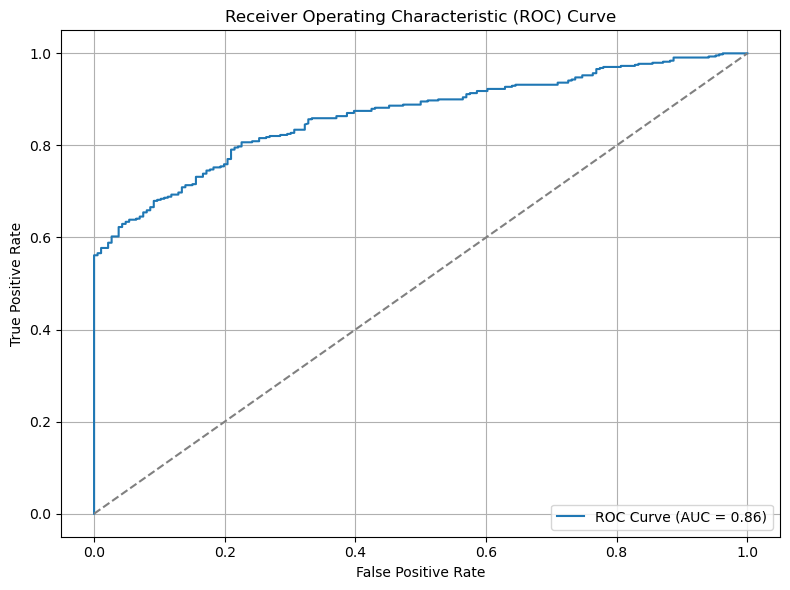

In [57]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## Data Pipeline and Logistic Regression Model

### Target Variable
- **Inspection Passed** (`True` if passed, `False` if failed)

---

### Features Used

#### **Numeric Features**
- `Turnover`
- `Free Chlorine, Shallow`
- `Free Chlorine, Deep`
- `Combined Chlorine, Shallow`
- `Combined Chlorine, Deep`

#### **Categorical Features**
- `Venue Type`
- `Facility Municipality Name`
- `Facility City`
- `Inspection Purpose`
- `Inspection Month`
- `Inspection Year`
- `pH Value, Shallow (Category)`
- `pH Value, Deep (Category)`
- `Cyanuric Acid (Category)`
- `Free Bromine, Shallow (Exists)`
- `Free Bromine, Deep (Exists)`

> **Note:** We excluded post-inspection outcome variables such as `Main Drain Visible`, `Safety Equipment`, `pH Balance`, and `No Imminent Health Hazards` to avoid **data leakage** (i.e., using information that wouldn’t be available before inspection).

---

### Preprocessing Pipelines

#### **Numeric Pipeline**
- Impute missing values using `median`
- Scale using `StandardScaler`

#### **Categorical Pipeline**
- Impute missing values using `most_frequent`
- One-hot encode using `OneHotEncoder(handle_unknown='ignore')`

> Combined using `ColumnTransformer`.

---

### Train/Test Split
- **80/20 stratified split** on `Inspection Passed`
- `random_state = 42`

---

### Model
- **Logistic Regression**
  - `max_iter = 1000`

---

### Model Performance (Test Set)

#### Classification Report

| Class  | Precision | Recall | F1-Score | Support |
|--------|-----------|--------|----------|---------|
| False  | 0.66      | 0.67   | 0.66     | 186     |
| True   | 0.86      | 0.85   | 0.86     | 440     |
| **Accuracy**     |         |         | **0.80**  | 626     |
| **Macro Avg**    | 0.76    | 0.76    | 0.76     | 626     |
| **Weighted Avg** | 0.80    | 0.80    | 0.80     | 626     |

---

#### Extended Metrics

| Metric                  | Value  |
|-------------------------|--------|
| **Accuracy**            | 0.799  |
| **Recall (Sensitivity)**| 0.852  |
| **Specificity**         | 0.672  |
| **False Positive Rate** | 0.328  |
| **Precision**           | 0.860  |
| **F1 Score**            | 0.856  |

---

### Next Steps

- Use `GridSearchCV` for **hyperparameter tuning**
- Try other models: **Random Forest**, **XGBoost**, **SVM**
- Use **SHAP** to interpret feature impact
- Consider **PCA** or feature selection to reduce dimensionality
- Tune **classification threshold** to balance precision/recall tradeoffs
- Consider sampling methods like **SMOTE** if class imbalance arises



## 6.5. Stratified K-Fold Cross Validation

In [58]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=skf, scoring='f1_macro')

scores.mean(), scores.std(), scores

(0.7356475729627647,
 0.01931424163203426,
 array([0.75341244, 0.74307692, 0.72295383, 0.7544488 , 0.70434587]))

### Stratified K-Fold Cross-Validation Results

We applied **Stratified K-Fold Cross-Validation** with 5 folds to avoid data leakage and ensure the class distribution of `Inspection Passed` remains consistent across each split.

- **Cross-validation strategy**: `StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`
- **Scoring metric**: `f1_macro` (to balance precision and recall across both classes)

**Results:**

- Mean F1 Macro Score: **0.736**
- Standard Deviation: **0.019**
- Individual fold scores:
  - Fold 1: 0.753
  - Fold 2: 0.743
  - Fold 3: 0.723
  - Fold 4: 0.754
  - Fold 5: 0.704

**Interpretation**: The pipeline performs well and consistently across all folds, with a relatively low standard deviation. This suggests the model is generalizing well across different subsets of the data with only modest variation in performance.


## 7. Feature Importance and SHAP

In [59]:
encoded_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_feature_names)

coefficients = pipeline.named_steps['classifier'].coef_[0]

import pandas as pd

coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

coef_df

,Feature,Coefficient
144,Inspection Purpose_FOLLOW UP INSPECTION,2.698947
145,Inspection Purpose_INITIAL INSPECTION,-2.666368
165,"pH Value, Shallow (Category)_Ideal",-1.831983
84,Facility Municipality Name_Wilkins Township,1.634242
62,Facility Municipality Name_Penn Hills,1.512052
...,...,...
130,Facility City_Robinson,-0.006418
120,Facility City_Munhall,0.003925
98,Facility City_Clinton,0.003295
76,Facility Municipality Name_South Park Township,-0.002860


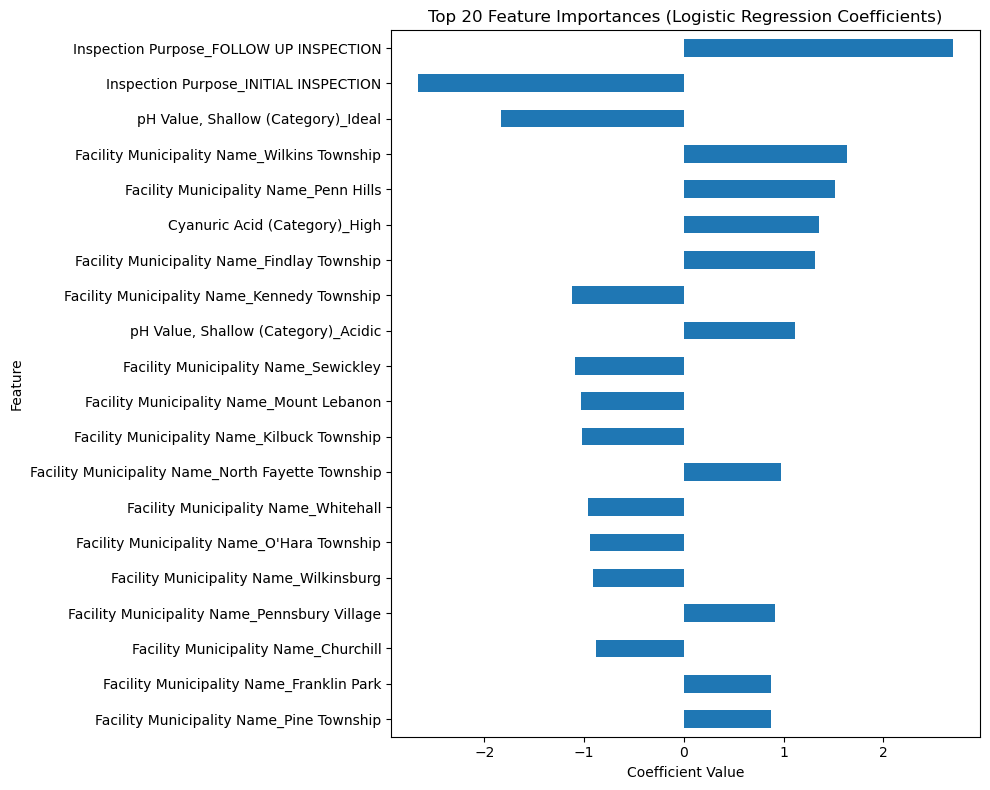

In [60]:
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['encoder']
ohe_features = ohe.get_feature_names_out(categorical_features)

all_features = list(numeric_features) + list(ohe_features)

coefs = pipeline.named_steps['classifier'].coef_[0]

importance_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 8))
importance_df.head(20).set_index('Feature').Coefficient.plot(kind='barh')
plt.title("Top 20 Feature Importances (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

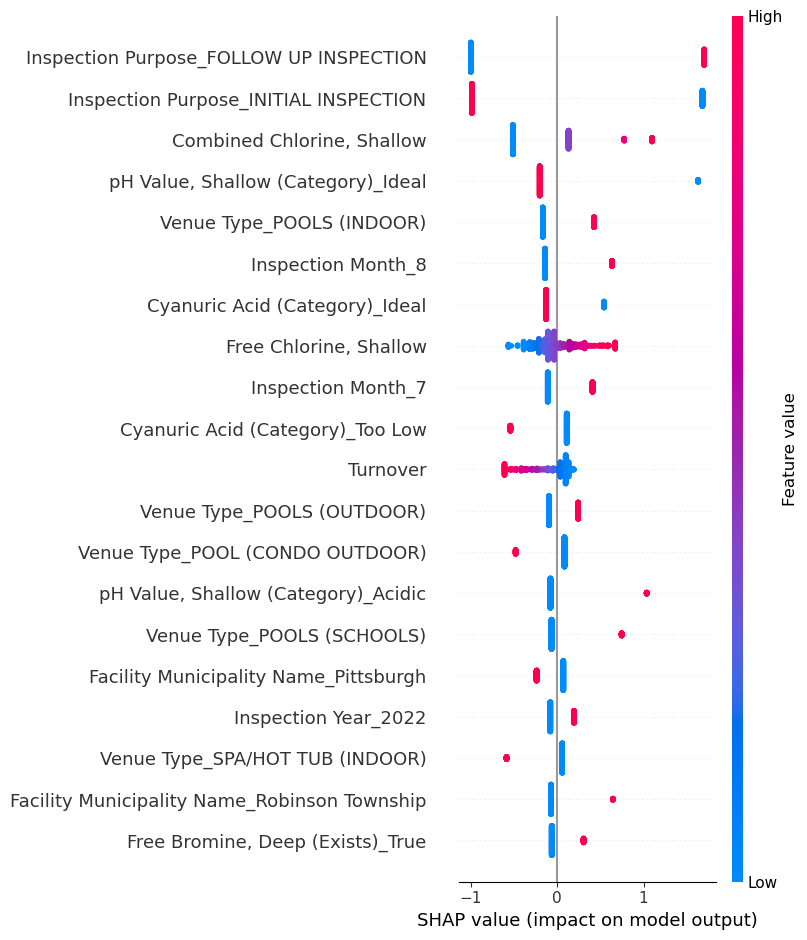

In [61]:
X_sample = preprocessor.transform(X_test)
explainer = shap.LinearExplainer(pipeline.named_steps['classifier'], X_sample)

shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names)

## Model Interpretation Summary (Updated)

### Logistic Regression Coefficients
This plot displays the **top 20 features** with the largest absolute coefficient values from the logistic regression model, indicating their **relative importance**.

- **Positive Coefficients (→ right)**: Increase the likelihood of passing inspection  
- **Negative Coefficients (← left)**: Decrease the likelihood of passing

#### Key Observations:
- `Inspection Purpose_FOLLOW UP INSPECTION` and `INITIAL INSPECTION` have **strong positive effects**, reinforcing their predictive value.
- `pH Value, Shallow (Category)_Ideal` is **positively associated** with passing.
- Multiple **municipalities** such as `Wilkins Township`, `Penn Hills`, and `Findlay Township` are **positively associated** with passing.
- Some municipalities like `Kennedy Township` and `Churchill` show a **negative association**, potentially indicating regional disparities.

---

### SHAP Summary Plot
SHAP (SHapley Additive exPlanations) helps explain the **magnitude and direction** of feature impact for individual predictions.

- **X-axis**: SHAP value — positive means pushing prediction toward “pass”, negative toward “fail”.
- **Color**:  
  - 🔴 = High feature value  
  - 🔵 = Low feature value  
- **Each dot**: An individual inspection case

#### Insights from SHAP:
- `Inspection Purpose` continues to dominate with high SHAP impact.
- **Chlorine levels** (`Combined Chlorine, Shallow` and `Free Chlorine, Shallow`) are **important drivers of passing**.
- `pH Value, Shallow (Category)_Ideal` and `Cyanuric Acid (Category)_Ideal` both show strong **positive contributions**.
- `Turnover`, when low (🔵), tends to **reduce passing likelihood**, reflecting stagnant water risks.
- Certain venue types (e.g., `POOLS (OUTDOOR)`, `SCHOOLS`) **increase the chance of passing**.

---

### Takeaways
- **Chemical balance is critical**: Ideal pH, chlorine, and cyanuric acid levels are consistently strong predictors of passing.
- **Inspection type** is the **single most influential categorical feature**.
- **Temporal and location-based variables** such as inspection month, municipality, and venue type carry **notable predictive power**.
- SHAP values and logistic regression coefficients provide **complementary perspectives**:  
  - Coefficients show **directional influence** on the overall model.  
  - SHAP reveals **individual inspection-level contributions**.

---




## 8. Compare witth Some Other Models

In [62]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

for name, model in models.items():
    clf = Pipeline([
        ('preprocess', preprocessor),
        ('classifier', model)
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred), 3))
    print("Recall:", round(recall_score(y_test, y_pred), 3))
    print("F1 Score:", round(f1_score(y_test, y_pred), 3))


Logistic Regression Results:
              precision    recall  f1-score   support

       False       0.66      0.67      0.66       186
        True       0.86      0.85      0.86       440

    accuracy                           0.80       626
   macro avg       0.76      0.76      0.76       626
weighted avg       0.80      0.80      0.80       626

Accuracy: 0.799
Precision: 0.86
Recall: 0.852
F1 Score: 0.856

Random Forest Results:
              precision    recall  f1-score   support

       False       0.66      0.67      0.67       186
        True       0.86      0.86      0.86       440

    accuracy                           0.80       626
   macro avg       0.76      0.76      0.76       626
weighted avg       0.80      0.80      0.80       626

Accuracy: 0.802
Precision: 0.861
Recall: 0.857
F1 Score: 0.859

XGBoost Results:
              precision    recall  f1-score   support

       False       0.65      0.69      0.67       186
        True       0.87      0.85      0

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:56:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Gradient Boosting Results:
              precision    recall  f1-score   support

       False       0.63      0.67      0.65       186
        True       0.86      0.84      0.85       440

    accuracy                           0.79       626
   macro avg       0.75      0.75      0.75       626
weighted avg       0.79      0.79      0.79       626

Accuracy: 0.788
Precision: 0.858
Recall: 0.836
F1 Score: 0.847

Extra Trees Results:
              precision    recall  f1-score   support

       False       0.67      0.66      0.66       186
        True       0.86      0.86      0.86       440

    accuracy                           0.80       626
   macro avg       0.76      0.76      0.76       626
weighted avg       0.80      0.80      0.80       626

Accuracy: 0.802
Precision: 0.857
Recall: 0.861
F1 Score: 0.859

SVM Results:
              precision    recall  f1-score   support

       False       0.63      0.67      0.65       186
        True       0.86      0.83      0.84    

## Model Comparison Summary

We evaluated multiple models using the same training and test sets to predict whether a pool/spa inspection passed. Performance was compared using standard classification metrics.

### Performance Table

| Model                | Accuracy | Precision | Recall | F1 Score |
|---------------------|----------|-----------|--------|----------|
| **Logistic Regression** | 0.799    | 0.860     | 0.852  | 0.856    |
| **Random Forest**       | **0.802**| 0.861     | 0.857  | **0.859**|
| **XGBoost**             | 0.800    | **0.867** | 0.845  | 0.856    |
| **Gradient Boosting**   | 0.788    | 0.858     | 0.836  | 0.847    |
| **Extra Trees**         | **0.802**| 0.857     | **0.861** | **0.859**|
| **SVM (Linear Kernel)** | 0.784    | 0.855     | 0.834  | 0.845    |
| **LightGBM**            | 0.768    | 0.838     | 0.832  | 0.835    |
| **K-Nearest Neighbors** | 0.756    | 0.834     | 0.814  | 0.824    |
| **Naive Bayes**         | 0.690    | 0.962     | 0.582  | 0.725    |

---

### Key Takeaways

- **Random Forest** and **Extra Trees** are the top performers with highest F1 Scores (0.859) and accuracy (0.802).
- **XGBoost** offers the **best precision (0.867)** — useful when false positives are more costly than false negatives.
- **Logistic Regression** performs competitively and is more interpretable, especially useful for policy or clinical use cases.
- **Naive Bayes** shows poor recall — it misses many true positives despite high precision, likely due to strong independence assumptions.

---

## 9. Hyperparameter Tuning (Grid Search)

In [63]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'], 
    'classifier__solver': ['lbfgs']  
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best F1 Macro Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred)) #mapping results on correlation matrix

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best F1 Macro Score: 0.7302033551764031
              precision    recall  f1-score   support

       False       0.66      0.67      0.66       186
        True       0.86      0.85      0.86       440

    accuracy                           0.80       626
   macro avg       0.76      0.76      0.76       626
weighted avg       0.80      0.80      0.80       626



### Logistic Regression Hyperparameter Tuning (GridSearchCV)

- **Search Space**:
  - `C`: [0.01, 0.1, 1, 10, 100]
  - `penalty`: ['l2']
  - `solver`: ['lbfgs']

- **Cross-validation**:
  - `StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`
  - Scoring: `f1_macro`

- **Best Parameters**:
  - `C = 1`
  - `penalty = 'l2'`
  - `solver = 'lbfgs'`

- **Best F1 Macro Score**: **0.7302**

- **Test Set Results** (after tuning):
  - Accuracy: **0.80**
  - Precision: **0.86**
  - Recall: **0.85**
  - F1 Score: **0.86**

Our original Logistic Regression model was already near optimal. Grid search helps validate that C=1 with default regularization (l2) and the lbfgs solver performs well and doesn’t require further tuning.

## 10. PCA

In [64]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=10)),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [65]:
scaler = pipeline.named_steps['preprocess'].named_transformers_['num'].named_steps['scaler']

scaled_data = scaler.transform(X_train[numeric_features])
scaled_data

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[-0.65030242, -0.00519784,  0.05578396, -0.7560477 , -0.64110169],
       [-0.54191748, -0.00519784, -0.12406544,  0.56401327, -0.64110169],
       [-0.86707229, -0.00519784,  0.95503096,  0.56401327, -0.64110169],
       ...,
       [-0.59610995,  1.52875802,  2.21397677,  0.56401327,  1.11372847],
       [-0.5554656 ,  0.41315376, -0.30391484, -0.7560477 ,  1.11372847],
       [ 0.78579802,  0.55260429,  0.77518156,  0.56401327,  1.11372847]])

In [66]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.61      0.53      0.56       186
        True       0.81      0.86      0.83       440

    accuracy                           0.76       626
   macro avg       0.71      0.69      0.70       626
weighted avg       0.75      0.76      0.75       626



In [67]:
pca = pipeline.named_steps['pca']
print("Explained variance by each component:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Explained variance by each component: [0.1716151  0.16325949 0.09822605 0.04861553 0.04613314 0.04138464
 0.03682823 0.03253986 0.02995579 0.02917121]
Total variance explained: 0.6977290534941656


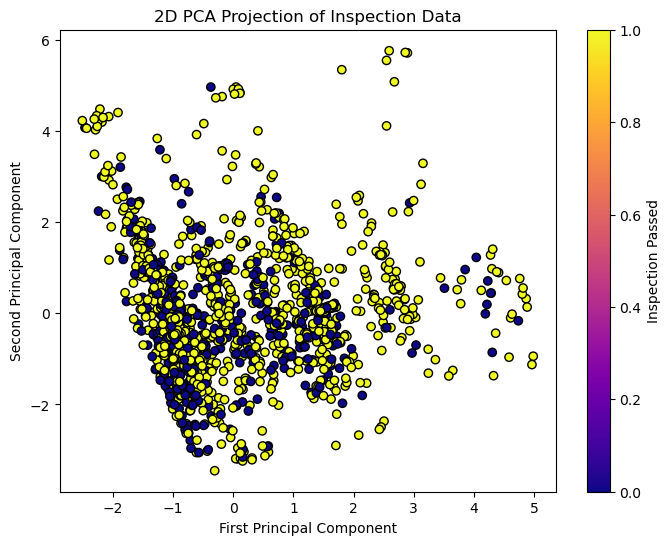

In [68]:
X_pca = pipeline.named_steps['pca'].transform(
    pipeline.named_steps['preprocess'].transform(X_train)
)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='plasma', edgecolor='k')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D PCA Projection of Inspection Data')
plt.colorbar(scatter, label='Inspection Passed')
plt.show()

## Performance Comparison: Original Logistic Regression vs. PCA-Based Model

We compared the performance of our original logistic regression model with a version that incorporated PCA for dimensionality reduction.

---

### Evaluation Metrics

| Metric           | Original Model | PCA Model |
|------------------|----------------|-----------|
| **Accuracy**     | 0.80           | 0.76      |
| **Precision**    | 0.86           | 0.81      |
| **Recall**       | 0.85           | 0.86      |
| **F1 Score**     | 0.86           | 0.83      |
| **Recall (False)** | 0.67         | 0.53      |

---

### PCA Variance Analysis

- **Explained variance by top 10 components**:  
  `[0.1716, 0.1633, 0.0982, 0.0486, 0.0461, 0.0414, 0.0368, 0.0325, 0.0300, 0.0292]`
- **Total variance explained (10 components)**: **~69.8%**

> This means PCA captures roughly 70% of the variance from the original features using the first 10 components.

---

### PCA Scatter Plot Interpretation

- The 2D PCA projection shows some separation between passed and failed inspections, but the classes are still significantly overlapping.
- This suggests that PCA is capturing some signal, but not enough to outperform the original model.

---

### Recommendation

We recommend **sticking with the original model**, because:

- It shows **better overall performance**, especially:
  - Higher **precision**, **accuracy**, and **F1 Score**
  - Stronger performance on the **minority class** (failed inspections)
- It is more **interpretable** — feature importances and SHAP values are clearer
- PCA added complexity without meaningful performance gains in this case

---
